In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette('Dark2')
sns.set_context('paper')
sns.set_style({'axes.axisbelow': True, 
               'axes.edgecolor': '.15',
               'axes.facecolor': 'white',
               'axes.grid': True, 
               'axes.labelcolor': '.15', 
               'figure.facecolor': 'white', 
               'grid.color': '.15',
               'grid.linestyle': ':', 
               'grid.alpha': .5, 
               'image.cmap': 'Greys', 
               'legend.frameon': False, 
               'legend.numpoints': 1, 
               'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'butt', 
               'axes.spines.right': False, 
               'axes.spines.top': False,  
               'text.color': '.15',  
               'xtick.top': False, 
               'ytick.right': False, 
               'xtick.color': '.15',
               'xtick.direction': 'out', 
               'ytick.color': '.15', 
               'ytick.direction': 'out', 
              })


import matplotlib

FONT_SIZE_PT = 5
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = FONT_SIZE_PT
matplotlib.rcParams['axes.labelsize'] = FONT_SIZE_PT
matplotlib.rcParams['axes.titlesize'] = FONT_SIZE_PT
matplotlib.rcParams['figure.titlesize'] = FONT_SIZE_PT
matplotlib.rcParams['xtick.labelsize'] = FONT_SIZE_PT
matplotlib.rcParams['ytick.labelsize'] = FONT_SIZE_PT
matplotlib.rcParams['legend.fontsize'] = FONT_SIZE_PT
matplotlib.rcParams['legend.title_fontsize'] = FONT_SIZE_PT

matplotlib.rcParams['xtick.major.size'] = matplotlib.rcParams['ytick.major.size'] = 2
matplotlib.rcParams['xtick.major.width'] = matplotlib.rcParams['ytick.major.width'] = 0.5


matplotlib.rcParams['xtick.minor.size'] = matplotlib.rcParams['ytick.minor.size'] = 1

matplotlib.rcParams['xtick.minor.width'] = matplotlib.rcParams['ytick.minor.width'] = 0.5

matplotlib.rcParams['axes.linewidth'] = 0.5
matplotlib.rcParams['lines.linewidth'] = 0.5
matplotlib.rcParams['grid.linewidth'] = 0.25
matplotlib.rcParams['patch.linewidth'] = 0.25
matplotlib.rcParams['lines.markeredgewidth'] = 0.25
matplotlib.rcParams['lines.markersize'] = 2

FIVE_MM_IN_INCH = 0.19685
DPI = 600
matplotlib.rcParams['figure.figsize'] = (10 * FIVE_MM_IN_INCH, 9 * FIVE_MM_IN_INCH)
matplotlib.rcParams['savefig.dpi'] = DPI
matplotlib.rcParams['figure.dpi'] = DPI // 4


#http://phyletica.org/matplotlib-fonts/
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# (04) MARCS result integration

At this point it is time to link the ChIP-MS results and MARCS data

## Configuration

In [2]:
import pathlib

INPUT_MARCS_DATA = pathlib.Path('outputs') / '02-linking-to-MARCS' / '03-mapping-between-chip-ms-and-marcs-features.csv'
assert INPUT_MARCS_DATA.is_file()

INPUT_GENE_LABEL_MAP = pathlib.Path('outputs') / '02-linking-to-MARCS' /  '02-marcs-to-chip-ms-mapping.csv'
assert INPUT_GENE_LABEL_MAP.is_file()

INPUT_MODEL_RESULTS = pathlib.Path('outputs') / '03-transformation-and-modelling' / '07-output-full_results.csv'
assert INPUT_MODEL_RESULTS.is_file()

In [3]:
MODEL_COEFS = [
    'H3K4me1vsControl',
    'H3K4me3vsControl',
    'H3K4me3vsH3K4me1',
]

MARCS_FEATURE_ORDER = [
    # Same order as in Fig 3
    'H2A.Z', 'meDNA', 
    'H3K4me1', 'H3K4me3', 'H3ac', 'H3K9acK14ac', 'H3K27ac', 
    'H3K9me2', 'H3K9me3', 'H3K27me2', 'H3K27me3',
    'H4ac', 'H4K16ac', 'H4K20me2', 'H4K20me3',         
]

In [4]:
import pathlib
OUTPUT_DIRECTORY = pathlib.Path('outputs') / '04-integrating-results-with-MARCS'

if not OUTPUT_DIRECTORY.is_dir():
    OUTPUT_DIRECTORY.mkdir(parents=True)

## Reading prepared MARCS data



First we load the mapping between ChIP-MS and MARCS identifiers

In [5]:
data_marcs_label_map = pd.read_csv(INPUT_GENE_LABEL_MAP, index_col=0)
data_marcs_label_map

marcs_gene_label chip_ms_label           mapped_via
0          ACIN1 (1)         ACIN1  Accession;Gene name
1          ACIN1 (2)         ACIN1            Gene name
2          ACIN1 (3)         ACIN1            Gene name
3          ACIN1 (4)         ACIN1            Gene name
4               ACTB          ACTB  Accession;Gene name
..               ...           ...                  ...
568          ZMYND11       ZMYND11  Accession;Gene name
569           ZNF326        ZNF326  Accession;Gene name
570           ZNF512        ZNF512  Accession;Gene name
571          ZNF512B       ZNF512B  Accession;Gene name
572           ZRANB2        ZRANB2  Accession;Gene name

[573 rows x 3 columns]

Now we load the MARCS feature data prepared in the earlier notebooks

In [6]:
data_marcs_features = pd.read_csv(INPUT_MARCS_DATA, index_col=0)
data_marcs_features.columns = pd.MultiIndex.from_tuples([c.split('__') for c in data_marcs_features.columns], names=['marcs_stat', 'marcs_feature'])
data_marcs_features

marcs_stat    95% CI (+/-)                                                    \
marcs_feature        H2A.Z   H3K27ac  H3K27me2  H3K27me3   H3K4me1   H3K4me3   
chip_ms_label                                                                  
ACIN1             0.211802  0.457351  0.200362  0.211652  0.269613  0.251001   
ACTA2             0.136765  0.159660  0.401742  0.105261  0.102875  0.115300   
ACTB              0.149708  0.228745  0.225918  0.114453  0.111949  0.152387   
ACTL6A            0.282852  0.143716  0.220205  0.081028  0.071553  0.118745   
ADAR              0.138593  0.205294  0.137140  0.089515  0.120810  0.182271   
...                    ...       ...       ...       ...       ...       ...   
SSB                    NaN       NaN       NaN       NaN       NaN       NaN   
TIA1                   NaN       NaN       NaN       NaN       NaN       NaN   
TIAL1                  NaN       NaN       NaN       NaN       NaN       NaN   
XPO1                   NaN       NaN       NaN       NaN       NaN       NaN   
ZNF512                 NaN  0.321946       NaN       NaN       NaN       NaN   

marcs_stat                                               ...  \
marcs_feature H3K9acK14ac   H3K9me2   H3K9me3      H3ac  ...   
chip_ms_label                                            ...   
ACIN1            0.145687  0.180162  0.231665  0.162215  ...   
ACTA2            0.140245  0.400128  0.147988  0.144921  ...   
ACTB             0.137878  0.179468  0.148311  0.180897  ...   
ACTL6A           0.128804  0.231306  0.093425  0.162082  ...   
ADAR             0.102996  0.147409  0.089110  0.101751  ...   
...                   ...       ...       ...       ...  ...   
SSB                   NaN       NaN  0.106573       NaN  ...   
TIA1                  NaN       NaN  0.109572       NaN  ...   
TIAL1                 NaN       NaN  0.109572       NaN  ...   
XPO1                  NaN       NaN  0.564072       NaN  ...   
ZNF512                NaN       NaN       NaN       NaN  ...   

marcs_stat    t statistic (moderated)                                  \
marcs_feature                 H3K4me3 H3K9acK14ac   H3K9me2   H3K9me3   
chip_ms_label                                                           
ACIN1                        2.950435   -2.996371  1.970440 -3.132679   
ACTA2                        2.974474   20.652988 -1.408574  0.621017   
ACTB                         2.222446   20.864091  1.126476  0.931822   
ACTL6A                       2.972668   19.593866 -1.219388 -0.122811   
ADAR                         2.751459   -4.002974  1.212874 -1.611738   
...                               ...         ...       ...       ...   
SSB                               NaN         NaN       NaN  0.606704   
TIA1                              NaN         NaN       NaN  2.377367   
TIAL1                             NaN         NaN       NaN  2.377367   
XPO1                              NaN         NaN       NaN -0.327175   
ZNF512                            NaN         NaN       NaN       NaN   

marcs_stat                                                                   
marcs_feature       H3ac   H4K16ac  H4K20me2  H4K20me3      H4ac      meDNA  
chip_ms_label                                                                
ACIN1          -3.998931 -1.325173 -4.314919  3.179548  1.586292  -0.650315  
ACTA2          22.407837  2.748171  4.271652  0.000565  6.184322  -4.371167  
ACTB           17.952188  3.376827  3.599880 -0.312255  6.602180  -7.888528  
ACTL6A         16.775046  2.850633  3.277666 -0.078187  7.699869 -13.615176  
ADAR           -5.584594 -0.795835 -4.750740 -0.597883 -1.235132  -2.406844  
...                  ...       ...       ...       ...       ...        ...  
SSB                  NaN       NaN       NaN       NaN       NaN        NaN  
TIA1                 NaN       NaN       NaN       NaN       NaN        NaN  
TIAL1                NaN       NaN       NaN       NaN       NaN        NaN  
XPO1                 Na

## Reading Model outputs

In [7]:
data_model_outputs = pd.read_csv(INPUT_MODEL_RESULTS, index_col=0)
data_model_outputs.columns = pd.MultiIndex.from_tuples([c.split('__') for c in data_model_outputs.columns])
data_model_outputs

normalised_data                                                         \
                  H3_1       H3_2       H3_3       H4_1       H4_2       H4_3   
Label                                                                           
GBE1               NaN        NaN        NaN        NaN  15.376077        NaN   
EFTUD2       17.529162  17.503392  16.539555  16.318518  18.794640  14.775579   
YWHAB        17.500332  18.489014  19.051719  17.253775  18.609681  17.226879   
YWHAE        17.978340  17.660600        NaN  17.732780  17.729887  18.127845   
YWHAH        26.469061  27.598393  28.196840  25.482620  26.254161  25.594706   
...                ...        ...        ...        ...        ...        ...   
ZNF800       20.116863  19.957744  18.762092  17.107449  19.010215  18.496467   
ZRANB2       16.632241  17.698422        NaN        NaN  17.080012  16.884347   
ZFR                NaN        NaN        NaN  17.975881  17.715118        NaN   
AZGP1        22.342637  22.993326  23.047930  21.558046  21.965314  21.835160   
ZYX          17.617100  18.514837  18.768639  17.321350  19.223079        NaN   

                                                    ... coefficient_estimates  \
        H3K4me3_1  H3K4me3_2  H3K4me3_3  H3K4me1_1  ...     ExperimentH3K4me3   
Label                                               ...                         
GBE1          NaN  17.325027        NaN        NaN  ...                   NaN   
EFTUD2  20.041195  19.531290  19.353650  20.006004  ...             19.642045   
YWHAB   19.144883  20.010644  19.970746  19.625605  ...             19.708758   
YWHAE   19.045548  19.793507  19.774640  18.833497  ...             19.537898   
YWHAH   27.232678  27.759508  27.235605  25.612516  ...             27.409264   
...           ...        ...        ...        ...  ...                   ...   
ZNF800  22.306802  21.887212  21.924212  20.914221  ...             22.039409   
ZRANB2  17.373421  18.116876  19.007300  18.309003  ...             18.165866   
ZFR           NaN  20.647178  21.060608  20.466560  ...             20.853893   
AZGP1   22.980912  23.683567  23.236657  23.185682  ...             23.300378   
ZYX     19.094547  20.335859  19.638187  19.054569  ...             19.689531   

       H3K4me1vsControl                                                   \
          logFC_imputed logFC_is_imputed logFC_based_on_single_datapoint   
Label                                                                      
GBE1                NaN              NaN                             NaN   
EFTUD2         1.779547            False                           False   
YWHAB          0.496726            False                           False   
YWHAE          0.831718            False                           False   
YWHAH         -0.254029            False                           False   
...                 ...              ...                             ...   
ZNF800         1.931435            False                           False   
ZRANB2         1.235248            False                            True   
ZFR            1.866238             True                           False   
AZGP1          1.158054            False                           False   
ZYX            0.768366            False                            True   

       H3K4me3vsControl                                                   \
          logFC_imputed logFC_is_imputed logFC_based_on_single_datapoint   
Label                                                                      
GBE1                NaN              NaN                             NaN   
EFTUD2         2.731904            False                           False   
YWHAB          1.686858            False                           False   
YWHAE          1.696411            False                           False   
YWHAH          0.809967            False                           False   
...                 ...              ...                        

## Significance testing (MWU)

We will now use Mann-Whitney-U (MWU) test to check whether any of the MARCS features have higher or lower-than average (imputed) estimates of logFC in the model, for the three parameters we tested.

In [8]:
TREATMENT_FEATURE_CATEGORIES = ['Strongly recruited', 'Strongly excluded']
CONTROL_FEATURE_CATEGORIES = ['Neither', 'N/A']

MIN_N_TREATMENT = 5

# In the code below, infinities will be replaced by [maximum value] + EPSILON (or [minimum value] - EPSILON)
# in order to still be able to calculate average differences.
EPSILON = 0.01

In [9]:
import pingouin as pg

For the stats calculations we will only consider the proteins that have their MARCS counterparts

(otherwise it is not a very fair comparison)

In [10]:
mapped_to_marcs_index = data_model_outputs.index.intersection(data_marcs_label_map['chip_ms_label'].unique())
mapped_to_marcs_index

Index(['EFTUD2', 'SFN', 'RPS10', 'RPS11', 'RPS12', 'RPS13', 'RPS14', 'RPS15',
       'RPS15A', 'RPS16',
       ...
       'YBX1', 'YLPM1', 'ZC3H18', 'ZC3HAV1', 'ZMYM3', 'ZMYND11', 'ZNF512',
       'ZNF512B', 'ZRANB2', 'ZFR'],
      dtype='object', name='Label', length=527)

Below we compute MWU statistics for all proteins mapped to marcs, 
for each feature comparing "Significantly recruited" group to (Neither, N/A) groups, and "Significantly excluded" group to (Neither, N/A) groups.

We operate on imputed fold changes, some of which can be infinite.
To alleviate for this we replace the infinity with the maximum value plus a small number (`EPSILON` above) (or minimum value minus a small number, in case of negative infinity).

This allows us to compute the log2 fold changes between MARCS feature associated proteins and the controls (which is just the difference of respective means, as data is already in log2 scale).


The resulting MWU p-values are adjusted using BH procedure and threshold of 0.05 (for all coefficients together)

In [11]:
results_mwu = {}

# Loop through all coefs
for coef in MODEL_COEFS:
    
    # We will be doing significance testing for each coef separately:
    stats = []
    
    
    # We will work with imputed fold changes
    # Only consider proteins for which we have MARCS data 
    imputed_fold_changes = data_model_outputs[coef, 'logFC_imputed'].loc[mapped_to_marcs_index]
    
    # And whose imputed estimates are not NA
    imputed_fold_changes = imputed_fold_changes.dropna()
    
    # Find infinities and min, max values after removing them
    is_infinite = ~np.isfinite(imputed_fold_changes)
    
    _max = imputed_fold_changes[~is_infinite].max()
    _min = imputed_fold_changes[~is_infinite].min()
    
    # Replace infinities with maximum plus a small value
    # It won't matter for the non-parametric test but will still allow us
    # to visualise the mean differences
    imputed_fold_changes = imputed_fold_changes.replace(np.inf, _max+EPSILON)
    imputed_fold_changes = imputed_fold_changes.replace(-np.inf, _min-EPSILON)
    
    
    # Loop through MARCS Feature
    for marcs_feature in MARCS_FEATURE_ORDER:
        
        # Reindex by model outputs, 
        feature_assignments = data_marcs_features['significant_category_strong', marcs_feature].reindex(imputed_fold_changes.index).fillna('N/A')
        
        controls = imputed_fold_changes.loc[feature_assignments.isin(CONTROL_FEATURE_CATEGORIES)]
        n_controls = len(controls)
        
        controls_mean = controls.mean()
        controls_have_infinity = is_infinite.loc[controls.index].any()
        
        for treatment_cat in TREATMENT_FEATURE_CATEGORIES:
            
            treatment = imputed_fold_changes.loc[feature_assignments == treatment_cat]
            n_treatment = len(treatment)
            
            treatment_mean = treatment.mean()
            treatment_has_infinity = is_infinite.loc[treatment.index].any()
            
            log2fc = np.nan
            
            if not pd.isnull(treatment_mean) and not pd.isnull(controls_mean):
                log2fc = treatment_mean - controls_mean
            
            d = {'marcs_feature': marcs_feature, 
                 'treatment_cat': treatment_cat, 
                 'n_controls': n_controls, 
                 'controls_mean': controls_mean, 
                 'controls_have_inf': controls_have_infinity,
                 'n_treatment': n_treatment,
                 'treatment_mean': treatment_mean,
                 'treatment_has_inf': treatment_has_infinity,
                 'log2fc_treatment_control': log2fc,
                }
           
            if n_treatment >= MIN_N_TREATMENT and n_controls >= MIN_N_TREATMENT:
                mwu_ans = pg.mwu(treatment, controls, alternative='two-sided').loc['MWU']
                d.update(mwu_ans)
                
            stats.append(d)

    stats = pd.DataFrame(stats)

    results_mwu[coef] = stats.set_index(['marcs_feature', 'treatment_cat'])
        
results_mwu = pd.concat(results_mwu, keys=results_mwu.keys(), axis=1)
results_mwu.columns.names = ['coef', 'stats']
results_mwu = results_mwu.stack('coef')

non_null_pval = ~results_mwu['p-val'].isnull()
results_mwu['significant'] = results_mwu['p-val-adj'] = np.nan
results_mwu.loc[non_null_pval, 'significant'], results_mwu.loc[non_null_pval, 'p-val-adj'] = pg.multicomp(results_mwu.loc[non_null_pval, 'p-val'].values, method='fdr_bh', alpha=0.05)

results_mwu

stats                                              CLES  RBC  U-val  \
marcs_feature treatment_cat      coef                                 
H2A.Z         Strongly recruited H3K4me1vsControl   NaN  NaN    NaN   
                                 H3K4me3vsControl   NaN  NaN    NaN   
                                 H3K4me3vsH3K4me1   NaN  NaN    NaN   
              Strongly excluded  H3K4me1vsControl   NaN  NaN    NaN   
                                 H3K4me3vsControl   NaN  NaN    NaN   
...                                                 ...  ...    ...   
H4K20me3      Strongly recruited H3K4me3vsControl   NaN  NaN    NaN   
                                 H3K4me3vsH3K4me1   NaN  NaN    NaN   
              Strongly excluded  H3K4me1vsControl   NaN  NaN    NaN   
                                 H3K4me3vsControl   NaN  NaN    NaN   
                                 H3K4me3vsH3K4me1   NaN  NaN    NaN   

stats                                             alternative  \
marcs_feature treatment_cat      coef                           
H2A.Z         Strongly recruited H3K4me1vsControl         NaN   
                                 H3K4me3vsControl         NaN   
                                 H3K4me3vsH3K4me1         NaN   
              Strongly excluded  H3K4me1vsControl         NaN   
                                 H3K4me3vsControl         NaN   
...                                                       ...   
H4K20me3      Strongly recruited H3K4me3vsControl         NaN   
                                 H3K4me3vsH3K4me1         NaN   
              Strongly excluded  H3K4me1vsControl         NaN   
                                 H3K4me3vsControl         NaN   
                                 H3K4me3vsH3K4me1         NaN   

stats                                              controls_have_inf  \
marcs_feature treatment_cat      coef                                  
H2A.Z         Strongly recruited H3K4me1vsControl               True   
                                 H3K4me3vsControl               True   
                                 H3K4me3vsH3K4me1               True   
              Strongly excluded  H3K4me1vsControl               True   
                                 H3K4me3vsControl               True   
...                                                              ...   
H4K20me3      Strongly recruited H3K4me3vsControl               True   
                                 H3K4me3vsH3K4me1               True   
              Strongly excluded  H3K4me1vsControl               True   
                                 H3K4me3vsControl               True   
                                 H3K4me3vsH3K4me1               True   

stats                                              controls_mean  \
marcs_feature treatment_cat      coef                              
H2A.Z         Strongly recruited H3K4me1vsControl       0.600475   
                                 H3K4me3vsControl       1.055377   
                                 H3K4me3vsH3K4me1       0.409183   
              Strongly excluded  H3K4me1vsControl       0.600475   
                                 H3K4me3vsControl       1.055377   
...                                                          ...   
H4K20me3      Strongly recruited H3K4me3vsControl       1.051288   
                                 H3K4me3vsH3K4me1       0.407986   
              Strongly excluded  H3K4me1vsControl       0.597758   
                                 H3K4me3vsControl       1.051288   
                                 H3K4me3vsH3K4me1       0.407986   

stats                                              log2fc_treatment_control  \
marcs_feature treatment_cat      coef                                         
H2A.Z         Strongly recruited H3K4me1vsControl                       NaN   
                                 H3K4me3vsControl                       NaN   
                                 H3K4me3vsH3K4me1                       NaN   
             

In [12]:
results_mwu[~results_mwu['p-val'].isnull()].sort_values(by='p-val')

stats                                                  CLES       RBC   U-val  \
marcs_feature treatment_cat      coef                                           
H3K4me3       Strongly recruited H3K4me3vsH3K4me1  0.957202 -0.914404  3243.0   
                                 H3K4me3vsControl  0.884536 -0.769072  3003.0   
              Strongly excluded  H3K4me3vsControl  0.212715  0.574570   619.0   
H4ac          Strongly recruited H3K4me1vsControl  0.679443 -0.358887  2978.0   
H3K9me3       Strongly recruited H3K4me3vsControl  0.318112  0.363776  1247.0   
H3K4me3       Strongly excluded  H3K4me1vsControl  0.317493  0.365014   922.0   
H3K9me3       Strongly recruited H3K4me1vsControl  0.349182  0.301636  1366.0   
meDNA         Strongly recruited H3K4me3vsControl  0.378804  0.242393  2191.0   
H3K4me3       Strongly excluded  H3K4me3vsH3K4me1  0.351928  0.296143  1022.0   
H3K9acK14ac   Strongly recruited H3K4me3vsControl  0.619177 -0.238355  2725.0   
H3K9me3       Strongly recruited H3K4me3vsH3K4me1  0.374489  0.251022  1465.0   
H4ac          Strongly recruited H3K4me3vsH3K4me1  0.400867  0.198266  1757.0   
meDNA         Strongly recruited H3K4me3vsH3K4me1  0.426542  0.146916  2462.0   
H3K4me3       Strongly recruited H3K4me1vsControl  0.404811  0.190378  1371.5   
H4ac          Strongly recruited H3K4me3vsControl  0.569444 -0.138889  2501.0   
H3K9acK14ac   Strongly recruited H3K4me3vsH3K4me1  0.545310 -0.090619  2395.0   
H3ac          Strongly recruited H3K4me3vsH3K4me1  0.465042  0.069916  2920.0   
meDNA         Strongly recruited H3K4me1vsControl  0.464310  0.071379  2680.0   
H3ac          Strongly recruited H3K4me3vsControl  0.475366  0.049269  2991.0   
H3K9acK14ac   Strongly recruited H3K4me1vsControl  0.527095 -0.054189  2315.0   
H3ac          Strongly recruited H3K4me1vsControl  0.513458 -0.026915  3224.0   

stats                                             alternative  \
marcs_feature treatment_cat      coef                           
H3K4me3       Strongly recruited H3K4me3vsH3K4me1   two-sided   
                                 H3K4me3vsControl   two-sided   
              Strongly excluded  H3K4me3vsControl   two-sided   
H4ac          Strongly recruited H3K4me1vsControl   two-sided   
H3K9me3       Strongly recruited H3K4me3vsControl   two-sided   
H3K4me3       Strongly excluded  H3K4me1vsControl   two-sided   
H3K9me3       Strongly recruited H3K4me1vsControl   two-sided   
meDNA         Strongly recruited H3K4me3vsControl   two-sided   
H3K4me3       Strongly excluded  H3K4me3vsH3K4me1   two-sided   
H3K9acK14ac   Strongly recruited H3K4me3vsControl   two-sided   
H3K9me3       Strongly recruited H3K4me3vsH3K4me1   two-sided   
H4ac          Strongly recruited H3K4me3vsH3K4me1   two-sided   
meDNA         Strongly recruited H3K4me3vsH3K4me1   two-sided   
H3K4me3       Strongly recruited H3K4me1vsControl   two-sided   
H4ac          Strongly recruited H3K4me3vsControl   two-sided   
H3K9acK14ac   Strongly recruited H3K4me3vsH3K4me1   two-sided   
H3ac          Strongly recruited H3K4me3vsH3K4me1   two-sided   
meDNA         Strongly recruited H3K4me1vsControl   two-sided   
H3ac          Strongly recruited H3K4me3vsControl   two-sided   
H3K9acK14ac   Strongly recruited H3K4me1vsControl   two-sided   
H3ac          Strongly recruited H3K4me1vsControl   two-sided   

stats                                              controls_have_inf  \
marcs_feature treatment_cat      coef                                  
H3K4me3       Strongly recruited H3K4me3vsH3K4me1               True   
                                 H3K4me3vsControl               True   
              Strongly excluded  H3K4me3vsControl               True   
H4ac          Strongly recruited H3K4me1vsControl               True   
H3K9me3       Strongly recruited H3K4me3vsControl               True   
H3K4me3       Strongly excluded  H3K4me1vsControl               True   
H3K9me3       Strongly recruited H3K4me1vsControl               

In [13]:
results_mwu.to_csv(OUTPUT_DIRECTORY / '01-mwu-test-results-coef-against-feature.csv')

### Overview of results

In [14]:
results_mwu.xs('H3K4me3vsControl', level='coef').sort_values(by='p-val').head(5)

stats                                 CLES       RBC   U-val alternative  \
marcs_feature treatment_cat                                                
H3K4me3       Strongly recruited  0.884536 -0.769072  3003.0   two-sided   
              Strongly excluded   0.212715  0.574570   619.0   two-sided   
H3K9me3       Strongly recruited  0.318112  0.363776  1247.0   two-sided   
meDNA         Strongly recruited  0.378804  0.242393  2191.0   two-sided   
H3K9acK14ac   Strongly recruited  0.619177 -0.238355  2725.0   two-sided   

stats                             controls_have_inf  controls_mean  \
marcs_feature treatment_cat                                          
H3K4me3       Strongly recruited               True       1.031117   
              Strongly excluded                True       1.031117   
H3K9me3       Strongly recruited               True       1.061704   
meDNA         Strongly recruited               True       1.050869   
H3K9acK14ac   Strongly recruited               True       1.041367   

stats                             log2fc_treatment_control  n_controls  \
marcs_feature treatment_cat                                              
H3K4me3       Strongly recruited                  2.544661         485   
              Strongly excluded                  -1.294591         485   
H3K9me3       Strongly recruited                 -0.648430         490   
meDNA         Strongly recruited                 -0.528137         482   
H3K9acK14ac   Strongly recruited                  0.548948         489   

stats                             n_treatment     p-val  treatment_has_inf  \
marcs_feature treatment_cat                                                  
H3K4me3       Strongly recruited            7  0.000475               True   
              Strongly excluded             6  0.015570              False   
H3K9me3       Strongly recruited            8  0.077606              False   
meDNA         Strongly recruited           12  0.151540              False   
H3K9acK14ac   Strongly recruited            9  0.220616              False   

stats                             treatment_mean significant  p-val-adj  
marcs_feature treatment_cat                                              
H3K4me3       Strongly recruited        3.575778        True   0.004991  
              Strongly excluded        -0.263474       False   0.108987  
H3K9me3       Strongly recruited        0.413274       False   0.325943  
meDNA         Strongly recruited        0.522732       False   0.397792  
H3K9acK14ac   Strongly recruited        1.590316       False   0.426624

In [15]:
results_mwu.xs('H3K4me1vsControl', level='coef').sort_values(by='p-val').head(5)

stats                                 CLES       RBC   U-val alternative  \
marcs_feature treatment_cat                                                
H4ac          Strongly recruited  0.679443 -0.358887  2978.0   two-sided   
H3K4me3       Strongly excluded   0.317493  0.365014   922.0   two-sided   
H3K9me3       Strongly recruited  0.349182  0.301636  1366.0   two-sided   
H3K4me3       Strongly recruited  0.404811  0.190378  1371.5   two-sided   
meDNA         Strongly recruited  0.464310  0.071379  2680.0   two-sided   

stats                             controls_have_inf  controls_mean  \
marcs_feature treatment_cat                                          
H4ac          Strongly recruited               True       0.588692   
H3K4me3       Strongly excluded                True       0.625392   
H3K9me3       Strongly recruited               True       0.600997   
H3K4me3       Strongly recruited               True       0.625392   
meDNA         Strongly recruited               True       0.597981   

stats                             log2fc_treatment_control  n_controls  \
marcs_feature treatment_cat                                              
H4ac          Strongly recruited                  0.543845         487   
H3K4me3       Strongly excluded                  -0.792095         484   
H3K9me3       Strongly recruited                 -0.201170         489   
H3K4me3       Strongly recruited                 -1.283043         484   
meDNA         Strongly recruited                 -0.199177         481   

stats                             n_treatment     p-val  treatment_has_inf  \
marcs_feature treatment_cat                                                  
H4ac          Strongly recruited            9  0.065065              False   
H3K4me3       Strongly excluded             6  0.124514              False   
H3K9me3       Strongly recruited            8  0.143451              False   
H3K4me3       Strongly recruited            7  0.387609               True   
meDNA         Strongly recruited           12  0.673333              False   

stats                             treatment_mean significant  p-val-adj  
marcs_feature treatment_cat                                              
H4ac          Strongly recruited        1.132537       False   0.325943  
H3K4me3       Strongly excluded        -0.166703       False   0.397792  
H3K9me3       Strongly recruited        0.399826       False   0.397792  
H3K4me3       Strongly recruited       -0.657651       False   0.581413  
meDNA         Strongly recruited        0.398804       False   0.785555

In [16]:
results_mwu.xs('H3K4me3vsH3K4me1', level='coef').sort_values(by='p-val').head(5)

stats                                 CLES       RBC   U-val alternative  \
marcs_feature treatment_cat                                                
H3K4me3       Strongly recruited  0.957202 -0.914404  3243.0   two-sided   
              Strongly excluded   0.351928  0.296143  1022.0   two-sided   
H3K9me3       Strongly recruited  0.374489  0.251022  1465.0   two-sided   
H4ac          Strongly recruited  0.400867  0.198266  1757.0   two-sided   
meDNA         Strongly recruited  0.426542  0.146916  2462.0   two-sided   

stats                             controls_have_inf  controls_mean  \
marcs_feature treatment_cat                                          
H3K4me3       Strongly recruited               True       0.363467   
              Strongly excluded                True       0.363467   
H3K9me3       Strongly recruited               True       0.414441   
H4ac          Strongly recruited               True       0.415771   
meDNA         Strongly recruited               True       0.405829   

stats                             log2fc_treatment_control  n_controls  \
marcs_feature treatment_cat                                              
H3K4me3       Strongly recruited                  3.555352         484   
              Strongly excluded                  -0.460238         484   
H3K9me3       Strongly recruited                 -0.400992         489   
H4ac          Strongly recruited                 -0.379446         487   
meDNA         Strongly recruited                 -0.281901         481   

stats                             n_treatment     p-val  treatment_has_inf  \
marcs_feature treatment_cat                                                  
H3K4me3       Strongly recruited            7  0.000033               True   
              Strongly excluded             6  0.212767              False   
H3K9me3       Strongly recruited            8  0.223470              False   
H4ac          Strongly recruited            9  0.308377              False   
meDNA         Strongly recruited           12  0.384958              False   

stats                             treatment_mean significant  p-val-adj  
marcs_feature treatment_cat                                              
H3K4me3       Strongly recruited        3.918819        True   0.000684  
              Strongly excluded        -0.096771       False   0.426624  
H3K9me3       Strongly recruited        0.013448       False   0.426624  
H4ac          Strongly recruited        0.036324       False   0.539660  
meDNA         Strongly recruited        0.123928       False   0.581413

In [17]:
results_mwu

stats                                              CLES  RBC  U-val  \
marcs_feature treatment_cat      coef                                 
H2A.Z         Strongly recruited H3K4me1vsControl   NaN  NaN    NaN   
                                 H3K4me3vsControl   NaN  NaN    NaN   
                                 H3K4me3vsH3K4me1   NaN  NaN    NaN   
              Strongly excluded  H3K4me1vsControl   NaN  NaN    NaN   
                                 H3K4me3vsControl   NaN  NaN    NaN   
...                                                 ...  ...    ...   
H4K20me3      Strongly recruited H3K4me3vsControl   NaN  NaN    NaN   
                                 H3K4me3vsH3K4me1   NaN  NaN    NaN   
              Strongly excluded  H3K4me1vsControl   NaN  NaN    NaN   
                                 H3K4me3vsControl   NaN  NaN    NaN   
                                 H3K4me3vsH3K4me1   NaN  NaN    NaN   

stats                                             alternative  \
marcs_feature treatment_cat      coef                           
H2A.Z         Strongly recruited H3K4me1vsControl         NaN   
                                 H3K4me3vsControl         NaN   
                                 H3K4me3vsH3K4me1         NaN   
              Strongly excluded  H3K4me1vsControl         NaN   
                                 H3K4me3vsControl         NaN   
...                                                       ...   
H4K20me3      Strongly recruited H3K4me3vsControl         NaN   
                                 H3K4me3vsH3K4me1         NaN   
              Strongly excluded  H3K4me1vsControl         NaN   
                                 H3K4me3vsControl         NaN   
                                 H3K4me3vsH3K4me1         NaN   

stats                                              controls_have_inf  \
marcs_feature treatment_cat      coef                                  
H2A.Z         Strongly recruited H3K4me1vsControl               True   
                                 H3K4me3vsControl               True   
                                 H3K4me3vsH3K4me1               True   
              Strongly excluded  H3K4me1vsControl               True   
                                 H3K4me3vsControl               True   
...                                                              ...   
H4K20me3      Strongly recruited H3K4me3vsControl               True   
                                 H3K4me3vsH3K4me1               True   
              Strongly excluded  H3K4me1vsControl               True   
                                 H3K4me3vsControl               True   
                                 H3K4me3vsH3K4me1               True   

stats                                              controls_mean  \
marcs_feature treatment_cat      coef                              
H2A.Z         Strongly recruited H3K4me1vsControl       0.600475   
                                 H3K4me3vsControl       1.055377   
                                 H3K4me3vsH3K4me1       0.409183   
              Strongly excluded  H3K4me1vsControl       0.600475   
                                 H3K4me3vsControl       1.055377   
...                                                          ...   
H4K20me3      Strongly recruited H3K4me3vsControl       1.051288   
                                 H3K4me3vsH3K4me1       0.407986   
              Strongly excluded  H3K4me1vsControl       0.597758   
                                 H3K4me3vsControl       1.051288   
                                 H3K4me3vsH3K4me1       0.407986   

stats                                              log2fc_treatment_control  \
marcs_feature treatment_cat      coef                                         
H2A.Z         Strongly recruited H3K4me1vsControl                       NaN   
                                 H3K4me3vsControl                       NaN   
                                 H3K4me3vsH3K4me1                       NaN   
             

### Heatmap

This draws a heatmap in a similar format to that of ChIP-Seq analysis

In [18]:
_df = results_mwu.copy()

_df = _df.reset_index().set_index(['coef', 'marcs_feature', 'treatment_cat'])

matrix = _df['log2fc_treatment_control'].unstack(['marcs_feature', 'treatment_cat'])
matrix_mask =  ~(_df['significant'].unstack(['marcs_feature', 'treatment_cat']).fillna(False))
matrix_pvals = _df['p-val-adj'].unstack(['marcs_feature', 'treatment_cat'])

matrix = matrix[MARCS_FEATURE_ORDER]
matrix_mask = matrix_mask[MARCS_FEATURE_ORDER]
matrix_pvals = matrix_pvals[MARCS_FEATURE_ORDER]

In [19]:
_matrix = matrix.copy()
_mask = matrix_mask.copy()
_pvals = matrix_pvals.copy()


_row_order = list(_matrix.index)
_col_order = ['-'.join(ix) for ix in _matrix.columns]

_row_coords = pd.Series(
    np.arange(len(_row_order), 0, -1) * 10.0 - 5, # times five because of matplotlib dendrogram madness,
    index=_row_order,
    name='row_coord'
)

_col_coords = pd.Series(
    np.arange(1, len(_col_order)+1) * 10.0 - 5, # times five because of matplotlib dendrogram madness
    index=_col_order,
    name='col_coord'
)


# Don't mess with the wide format, convert all into narrow
# To do this make sure we have normal indices column names
for _df in [_matrix, _mask, _pvals, _row_coords, _col_coords]:
    if isinstance(_df.index, pd.MultiIndex):
        _df.index = ['-'.join(ix) for ix in _df.index]
    
    if isinstance(_df, pd.DataFrame) and isinstance(_df.columns, pd.MultiIndex):
        _df.columns = ['-'.join(ix) for ix in _df.columns]

# A couple operations to force the matrix into long format:
_matrix_long = pd.concat([_matrix, _mask, _pvals], keys=['matrix', 'mask', 'pvals'])
_matrix_long = _matrix_long.stack()
_matrix_long.index.names = ['measurement', 'row_name', 'col_name']
_matrix_long = _matrix_long.unstack('measurement')
_matrix_long = _matrix_long.join(_row_coords, on='row_name')
_matrix_long = _matrix_long.join(_col_coords, on='col_name')

# Bin the p-values
# If you change the bins, change the legend code below too
_matrix_long['pvals_binned'] = pd.cut(_matrix_long['pvals'], bins=[0, 0.01, 0.05, 1.0])
assert len(_matrix_long.pvals_binned.cat.categories) == 3
_pval_kwarg_dict = dict(zip(_matrix_long.pvals_binned.cat.categories, [dict(s=30, marker='s', edgecolor='#525252', linewidth=0.45), dict(s=20, marker='s', edgecolor='#525252', linewidth=0.45), dict(s=10, marker='s', edgecolor='#CDCDCD', linewidth=0.45)]))
_ns_pval_group = _matrix_long.pvals_binned.cat.categories[-1]

In [20]:
_matrix_long

matrix  mask     pvals  \
row_name         col_name                                                
H3K4me1vsControl H2A.Z-Strongly recruited          NaN   1.0       NaN   
                 H2A.Z-Strongly excluded     -0.675016   1.0       NaN   
                 meDNA-Strongly recruited    -0.199177   1.0  0.785555   
                 meDNA-Strongly excluded      0.569919   1.0       NaN   
                 H3K4me1-Strongly recruited        NaN   1.0       NaN   
...                                                ...   ...       ...   
H3K4me3vsH3K4me1 H4K16ac-Strongly excluded         NaN   1.0       NaN   
                 H4K20me2-Strongly recruited       NaN   1.0       NaN   
                 H4K20me2-Strongly excluded  -0.447229   1.0       NaN   
                 H4K20me3-Strongly recruited       NaN   1.0       NaN   
                 H4K20me3-Strongly excluded        NaN   1.0       NaN   

                                              row_coord  col_coord  \
row_name         col_name                                            
H3K4me1vsControl H2A.Z-Strongly recruited          25.0        5.0   
                 H2A.Z-Strongly excluded           25.0       15.0   
                 meDNA-Strongly recruited          25.0       25.0   
                 meDNA-Strongly excluded           25.0       35.0   
                 H3K4me1-Strongly recruited        25.0       45.0   
...                                                 ...        ...   
H3K4me3vsH3K4me1 H4K16ac-Strongly excluded          5.0      255.0   
                 H4K20me2-Strongly recruited        5.0      265.0   
                 H4K20me2-Strongly excluded         5.0      275.0   
                 H4K20me3-Strongly recruited        5.0      285.0   
                 H4K20me3-Strongly excluded         5.0      295.0   

                                             pvals_binned  
row_name         col_name                                  
H3K4me1vsControl H2A.Z-Strongly recruited             NaN  
                 H2A.Z-Strongly excluded              NaN  
                 meDNA-Strongly recruited     (0.05, 1.0]  
                 meDNA-Strongly excluded              NaN  
                 H3K4me1-Strongly recruited           NaN  
...                                                   ...  
H3K4me3vsH3K4me1 H4K16ac-Strongly excluded            NaN  
                 H4K20me2-Strongly recruited          NaN  
                 H4K20me2-Strongly excluded           NaN  
                 H4K20me3-Strongly recruited          NaN  
                 H4K20me3-Strongly excluded           NaN  

[90 rows x 6 columns]

In [21]:
_matrix_long[~_matrix_long['pvals_binned'].isnull()].sort_values(by='pvals')

matrix  mask     pvals  \
row_name         col_name                                                   
H3K4me3vsH3K4me1 H3K4me3-Strongly recruited      3.555352   0.0  0.000684   
H3K4me3vsControl H3K4me3-Strongly recruited      2.544661   0.0  0.004991   
                 H3K4me3-Strongly excluded      -1.294591   1.0  0.108987   
                 H3K9me3-Strongly recruited     -0.648430   1.0  0.325943   
H3K4me1vsControl H4ac-Strongly recruited         0.543845   1.0  0.325943   
                 H3K4me3-Strongly excluded      -0.792095   1.0  0.397792   
                 H3K9me3-Strongly recruited     -0.201170   1.0  0.397792   
H3K4me3vsControl meDNA-Strongly recruited       -0.528137   1.0  0.397792   
                 H3K9acK14ac-Strongly recruited  0.548948   1.0  0.426624   
H3K4me3vsH3K4me1 H3K9me3-Strongly recruited     -0.400992   1.0  0.426624   
                 H3K4me3-Strongly excluded      -0.460238   1.0  0.426624   
                 H4ac-Strongly recruited        -0.379446   1.0  0.539660   
H3K4me1vsControl H3K4me3-Strongly recruited     -1.283043   1.0  0.581413   
H3K4me3vsH3K4me1 meDNA-Strongly recruited       -0.281901   1.0  0.581413   
H3K4me3vsControl H4ac-Strongly recruited         0.117919   1.0  0.665979   
H3K4me3vsH3K4me1 H3K9acK14ac-Strongly recruited  0.208017   1.0  0.785555   
                 H3ac-Strongly recruited        -0.249404   1.0  0.785555   
H3K4me1vsControl meDNA-Strongly recruited       -0.199177   1.0  0.785555   
                 H3K9acK14ac-Strongly recruited  0.387335   1.0  0.820413   
H3K4me3vsControl H3ac-Strongly recruited        -0.262791   1.0  0.820413   
H3K4me1vsControl H3ac-Strongly recruited         0.033455   1.0  0.869164   

                                                 row_coord  col_coord  \
row_name         col_name                                               
H3K4me3vsH3K4me1 H3K4me3-Strongly recruited            5.0       65.0   
H3K4me3vsControl H3K4me3-Strongly recruited           15.0       65.0   
                 H3K4me3-Strongly excluded            15.0       75.0   
                 H3K9me3-Strongly recruited           15.0      165.0   
H3K4me1vsControl H4ac-Strongly recruited              25.0      225.0   
                 H3K4me3-Strongly excluded            25.0       75.0   
                 H3K9me3-Strongly recruited           25.0      165.0   
H3K4me3vsControl meDNA-Strongly recruited             15.0       25.0   
                 H3K9acK14ac-Strongly recruited       15.0      105.0   
H3K4me3vsH3K4me1 H3K9me3-Strongly recruited            5.0      165.0   
                 H3K4me3-Strongly excluded             5.0       75.0   
                 H4ac-Strongly recruited               5.0      225.0   
H3K4me1vsControl H3K4me3-Strongly recruited           25.0       65.0   
H3K4me3vsH3K4me1 meDNA-Strongly recruited              5.0       25.0   
H3K4me3vsControl H4ac-Strongly recruited              15.0      225.0   
H3K4me3vsH3K4me1 H3K9acK14ac-Strongly recruited        5.0      105.0   
                 H3ac-Strongly recruited               5.0       85.0   
H3K4me1vsControl meDNA-Strongly recruited             25.0       25.0   
                 H3K9acK14ac-Strongly recruited       25.0      105.0   
H3K4me3vsControl H3ac-Strongly recruited              15.0       85.0   
H3K4me1vsControl H3ac-Strongly recruited              25.0       85.0   

                                                pvals_binned  
row_name         col_name                                     
H3K4me3vsH3K4me1 H3K4me3-Strongly recruited      (0.0, 0.01]  
H3K4me3vsControl H3K4me3-Strongly recruited      (0.0, 0.01]  
                 H3K4me3-Strongly excluded       (0.05, 1.0]  
                 H3K9me3-Strongly recruited      (0.05, 1.0]  
H3K4me1vsControl H4ac-Strongly recruited         (0.05, 1.0]  
                 H3K4me3-Strongly excluded       (0.05, 1.0]  
                 H3K9me3-Strongly recruited      (0.05, 1.0]  
H3K4me3vsControl meDNA-Strongly 

/var/folders/l5/c9g36v3d2sq081c_mw1ts558cnj5wc/T/ipykernel_21579/1956264174.py:62: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(_colours, ax=ax_legend, cax=cax, orientation='horizontal')
/var/folders/l5/c9g36v3d2sq081c_mw1ts558cnj5wc/T/ipykernel_21579/1956264174.py:102: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(_fname, bbox_inches='tight', dpi=DPI)



A summary result of statistical testing between MARCS feature categories and ChIP-MS dataset.

The p-values were computed using Mann-Whitney-U test (MWU), 
comparing the imputed logFC coefficient estimates from the model associated 
with MARCS feature category to the coefficients associated with proteins that either have no estimate from the category,
or the estimate is insignificant or significant, but "weak" (i.e. less than 1). The p-values were adjusted with Benjamini/Hochberg method for each of the coefficients 
independently.

The colour scale indicates a difference between the mean fold change estimate for the
MARCS category in the columns and the mean fold change associated with
the proteins that have either no marcs feature estimate in that category, or an estimate which is weak. 

Note that the imputed estimates were used for this calculation.
In order to be able to compute the averages in the presence of infinite me1/3 vs control enrichments (as is the case for some proteins

/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


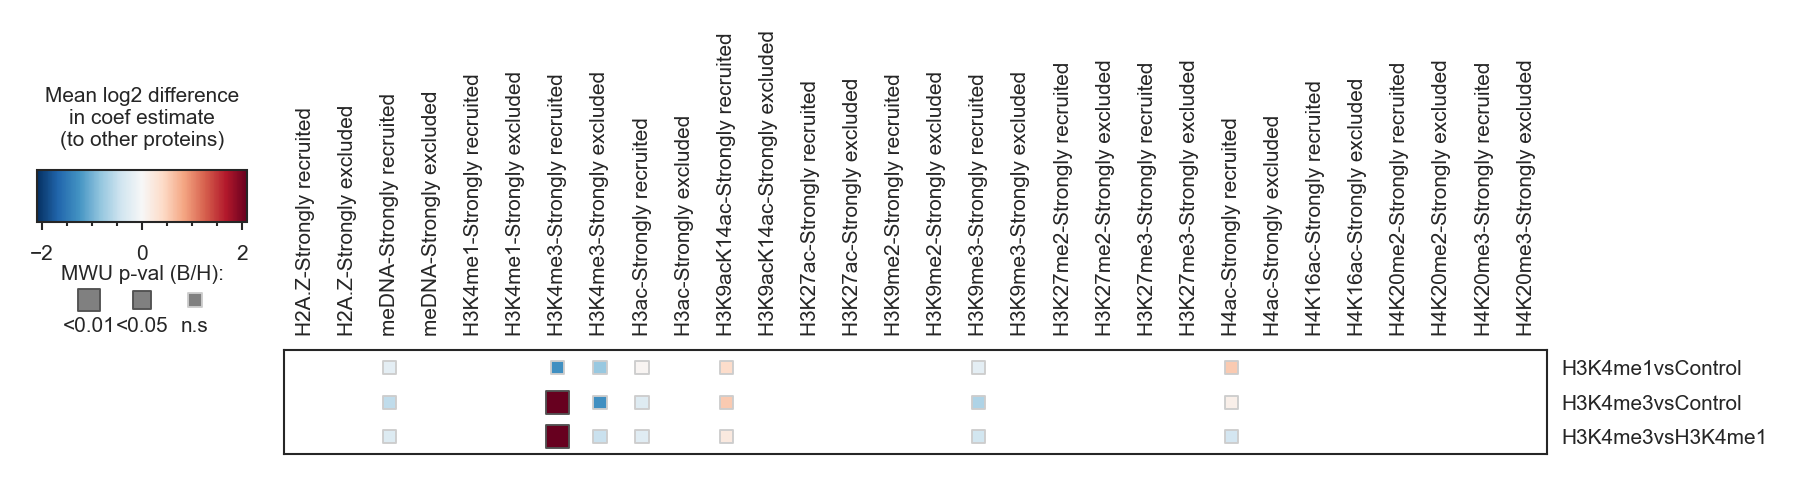

In [22]:
from matplotlib.gridspec import GridSpec

# Force the colour scale for min and max
_vmin = -2.1 # don't make this a round number (will help with the ticks)
_vmax = 2.1
_title = f'Mean log2 difference\nin coef estimate\n(to other proteins)'
_cmap = 'RdBu_r'

n_rows, n_cols = _matrix.shape

fig = plt.figure(
    figsize=(
        # four mm * (columns + dendrogram) + [labels]
        4/5*FIVE_MM_IN_INCH*(n_cols+5) + FIVE_MM_IN_INCH*5, 
        # four mm * (rows + dendrogram)
        4/5*FIVE_MM_IN_INCH*(n_rows+5+5),
    ),
    constrained_layout=True,
)

gs = GridSpec(3, 2, width_ratios=[5, n_cols], height_ratios=[5, n_rows, 5], wspace=0.05, hspace=0.05)

ax_heatmap = fig.add_subplot(gs[1,1])
ax_heatmap.invert_yaxis()
ax_heatmap.xaxis.tick_top()
ax_heatmap.yaxis.tick_right()

sns.despine(ax=ax_heatmap, bottom=False, right=False, top=False, left=False)
ax_heatmap.xaxis.set_tick_params(length=0)
ax_heatmap.yaxis.set_tick_params(length=0)

# Draw heatmap
for _pval_group, _submatrix in _matrix_long.groupby('pvals_binned'):
    
     _colours = ax_heatmap.scatter(
        _submatrix['col_coord'], 
        _submatrix['row_coord'], 
        c=_submatrix['matrix'], 
        vmin=_vmin, vmax=_vmax, 
        cmap=_cmap,
        **_pval_kwarg_dict[_pval_group],
    )
        
# Set ticks
_yticks = _row_coords.sort_values()
ax_heatmap.set_yticks(_yticks.values)
ax_heatmap.set_yticklabels(_yticks.index)

_xticks = _col_coords.sort_values()
ax_heatmap.set_xticks(_xticks.values)
ax_heatmap.set_xticklabels(_xticks.index, rotation=90)
ax_heatmap.grid(False)

ax_heatmap.set_xlim(_matrix_long['col_coord'].min() - 5, _matrix_long['col_coord'].max() + 5), 
ax_heatmap.set_ylim(_matrix_long['row_coord'].min() - 5, _matrix_long['row_coord'].max() + 5), 

# Add legends
ax_legend = fig.add_subplot(gs[0,0])

# Colourbar
cax = ax_legend.inset_axes([0.0, 0.7, 1.0, 0.3])
fig.colorbar(_colours, ax=ax_legend, cax=cax, orientation='horizontal')
cax.set_title(_title)
cax.minorticks_on()


# P-val legend
ax_legend.text(0.5, 0.4, 'MWU p-val (B/H):', ha='center', va='center')
assert len(_pval_kwarg_dict) == 3
ax_legend.scatter(0.25, 0.25, color='gray', **_pval_kwarg_dict[_matrix_long.pvals_binned.cat.categories[0]])
ax_legend.scatter(0.5, 0.25, color='gray', **_pval_kwarg_dict[_matrix_long.pvals_binned.cat.categories[1]])
ax_legend.scatter(0.75, 0.25, color='gray', **_pval_kwarg_dict[_matrix_long.pvals_binned.cat.categories[2]])

ax_legend.text(0.25, 0.15, '<0.01', ha='center', va='top')
ax_legend.text(0.5, 0.15, '<0.05', ha='center', va='top')
ax_legend.text(0.75, 0.15, 'n.s', ha='center', va='top')

ax_legend.set_ylim([0, 1])
ax_legend.set_xlim([0, 1])
ax_legend.axis('off')

_fname = OUTPUT_DIRECTORY / '02-mwu-heatmap-of-marcs-feature-enrichments.pdf'
_caption = f"""
A summary result of statistical testing between MARCS feature categories and ChIP-MS dataset.

The p-values were computed using Mann-Whitney-U test (MWU), 
comparing the imputed logFC coefficient estimates from the model associated 
with MARCS feature category to the coefficients associated with proteins that either have no estimate from the category,
or the estimate is insignificant or significant, but "weak" (i.e. less than 1). The p-values were adjusted with Benjamini/Hochberg method for each of the coefficients 
independently.

The colour scale indicates a difference between the mean fold change estimate for the
MARCS category in the columns and the mean fold change associated with
the proteins that have either no marcs feature estimate in that category, or an estimate which is weak. 

Note that the imputed estimates were used for this calculation.
In order to be able to compute the averages in the presence of infinite me1/3 vs control enrichments (as is the case for some proteins).
The infinities were temporarily replaced by the maximum observed value in the MARCS-associatable-dataset plus a small number ({EPSILON}).

Only the categories with at least {MIN_N_TREATMENT} proteins were analysed, remaining categories appear empty on this heatmap.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

## Heatmaps

### H3K4me3vsH3K4me1 centred

We will now attempt to visualise all significantly differential proteins (H3K4me3vsH3K4me1) and their relationship to MARCS.
We will also include proteins that have infinite enrichments that are not based on single datapoint.

In [23]:
data_model_outputs

normalised_data                                                         \
                  H3_1       H3_2       H3_3       H4_1       H4_2       H4_3   
Label                                                                           
GBE1               NaN        NaN        NaN        NaN  15.376077        NaN   
EFTUD2       17.529162  17.503392  16.539555  16.318518  18.794640  14.775579   
YWHAB        17.500332  18.489014  19.051719  17.253775  18.609681  17.226879   
YWHAE        17.978340  17.660600        NaN  17.732780  17.729887  18.127845   
YWHAH        26.469061  27.598393  28.196840  25.482620  26.254161  25.594706   
...                ...        ...        ...        ...        ...        ...   
ZNF800       20.116863  19.957744  18.762092  17.107449  19.010215  18.496467   
ZRANB2       16.632241  17.698422        NaN        NaN  17.080012  16.884347   
ZFR                NaN        NaN        NaN  17.975881  17.715118        NaN   
AZGP1        22.342637  22.993326  23.047930  21.558046  21.965314  21.835160   
ZYX          17.617100  18.514837  18.768639  17.321350  19.223079        NaN   

                                                    ... coefficient_estimates  \
        H3K4me3_1  H3K4me3_2  H3K4me3_3  H3K4me1_1  ...     ExperimentH3K4me3   
Label                                               ...                         
GBE1          NaN  17.325027        NaN        NaN  ...                   NaN   
EFTUD2  20.041195  19.531290  19.353650  20.006004  ...             19.642045   
YWHAB   19.144883  20.010644  19.970746  19.625605  ...             19.708758   
YWHAE   19.045548  19.793507  19.774640  18.833497  ...             19.537898   
YWHAH   27.232678  27.759508  27.235605  25.612516  ...             27.409264   
...           ...        ...        ...        ...  ...                   ...   
ZNF800  22.306802  21.887212  21.924212  20.914221  ...             22.039409   
ZRANB2  17.373421  18.116876  19.007300  18.309003  ...             18.165866   
ZFR           NaN  20.647178  21.060608  20.466560  ...             20.853893   
AZGP1   22.980912  23.683567  23.236657  23.185682  ...             23.300378   
ZYX     19.094547  20.335859  19.638187  19.054569  ...             19.689531   

       H3K4me1vsControl                                                   \
          logFC_imputed logFC_is_imputed logFC_based_on_single_datapoint   
Label                                                                      
GBE1                NaN              NaN                             NaN   
EFTUD2         1.779547            False                           False   
YWHAB          0.496726            False                           False   
YWHAE          0.831718            False                           False   
YWHAH         -0.254029            False                           False   
...                 ...              ...                             ...   
ZNF800         1.931435            False                           False   
ZRANB2         1.235248            False                            True   
ZFR            1.866238             True                           False   
AZGP1          1.158054            False                           False   
ZYX            0.768366            False                            True   

       H3K4me3vsControl                                                   \
          logFC_imputed logFC_is_imputed logFC_based_on_single_datapoint   
Label                                                                      
GBE1                NaN              NaN                             NaN   
EFTUD2         2.731904            False                           False   
YWHAB          1.686858            False                           False   
YWHAE          1.696411            False                           False   
YWHAH          0.809967            False                           False   
...                 ...              ...                        

In [24]:
coef = 'H3K4me3vsH3K4me1'
other_coefs = ['H3K4me3vsControl', 'H3K4me1vsControl']

# Take all proteins that are significant in the coef above as "interesting"
mask_interesting = data_model_outputs[coef, 'significant'].fillna(False)
# Also include all "infinite" proteins in the _coef_
mask_infinite = (~data_model_outputs[coef, 'logFC_imputed'].isnull()) # Not null
mask_infinite &= (~data_model_outputs[coef, 'logFC_imputed'].apply(np.isfinite)) # and not finite
# And not based on single datapoit
mask_infinite &= ~(data_model_outputs[coef, 'logFC_based_on_single_datapoint'].fillna(True))

mask_interesting |= mask_infinite

interesting_proteins = data_model_outputs[mask_interesting].index

# Sort the corresponding items by the coefficient fold change, then by other coefficient fold changes descending
interesting_proteins = data_model_outputs.loc[interesting_proteins].sort_values(by=[(c, 'logFC_imputed') for c in [coef] + other_coefs], ascending=False).index
matrix_diff_fold_change = data_model_outputs.loc[interesting_proteins, (coef, 'logFC_imputed')]

# We can now assign the row coordinates for them
row_coords = pd.Series(list(reversed(np.arange(1, len(interesting_proteins) + 1))), index=interesting_proteins, name='row_coord')

# Extract the model's matrix in long format
df = data_model_outputs[MODEL_COEFS].stack(level=0).loc[interesting_proteins]
df.index.names = ['Label', 'coef']

# Add an extra column
df['logFC_is_infinite'] = (~pd.isnull(df['logFC_imputed'])) & (~np.isfinite(df['logFC_imputed']))
# And add the row coordinate
df = df.join(row_coords)

In [25]:
df

B  P.Value  adj.P.Val  logFC  \
Label  coef                                              
CAPN2  H3K4me1vsControl NaN      NaN        NaN    NaN   
       H3K4me3vsControl NaN      NaN        NaN    NaN   
       H3K4me3vsH3K4me1 NaN      NaN        NaN    NaN   
COPB1  H3K4me1vsControl NaN      NaN        NaN    NaN   
       H3K4me3vsControl NaN      NaN        NaN    NaN   
...                      ..      ...        ...    ...   
EFEMP2 H3K4me3vsControl NaN      NaN        NaN    NaN   
       H3K4me3vsH3K4me1 NaN      NaN        NaN    NaN   
HRG    H3K4me1vsControl NaN      NaN        NaN    NaN   
       H3K4me3vsControl NaN      NaN        NaN    NaN   
       H3K4me3vsH3K4me1 NaN      NaN        NaN    NaN   

                        logFC_based_on_single_datapoint  logFC_imputed  \
Label  coef                                                              
CAPN2  H3K4me1vsControl                           False            NaN   
       H3K4me3vsControl                           False            inf   
       H3K4me3vsH3K4me1                           False            inf   
COPB1  H3K4me1vsControl                           False            NaN   
       H3K4me3vsControl                           False            inf   
...                                                 ...            ...   
EFEMP2 H3K4me3vsControl                           False            NaN   
       H3K4me3vsH3K4me1                           False           -inf   
HRG    H3K4me1vsControl                           False            inf   
       H3K4me3vsControl                           False            NaN   
       H3K4me3vsH3K4me1                           False           -inf   

                        logFC_is_imputed significant   t  logFC_is_infinite  \
Label  coef                                                                   
CAPN2  H3K4me1vsControl            False       False NaN              False   
       H3K4me3vsControl             True       False NaN               True   
       H3K4me3vsH3K4me1             True       False NaN               True   
COPB1  H3K4me1vsControl            False       False NaN              False   
       H3K4me3vsControl             True       False NaN               True   
...                                  ...         ...  ..                ...   
EFEMP2 H3K4me3vsControl            False       False NaN              False   
       H3K4me3vsH3K4me1             True       False NaN               True   
HRG    H3K4me1vsControl             True       False NaN               True   
       H3K4me3vsControl            False       False NaN              False   
       H3K4me3vsH3K4me1             True       False NaN               True   

                         row_coord  
Label  coef                         
CAPN2  H3K4me1vsControl        114  
       H3K4me3vsControl        114  
       H3K4me3vsH3K4me1        114  
COPB1  H3K4me1vsControl        113  
       H3K4me3vsControl        113  
...                            ...  
EFEMP2 H3K4me3vsControl          2  
       H3K4me3vsH3K4me1          2  
HRG    H3K4me1vsControl          1  
       H3K4me3vsControl          1  
       H3K4me3vsH3K4me1          1  

[342 rows x 11 columns]

Finally create a dataframe for MARCS features that we will use to plot too:

In [26]:
df_marcs_features = data_marcs_features[['Effect', 'significant', 'significant_category_strong']].stack(level='marcs_feature')
df_marcs_features = df_marcs_features.join(row_coords, on='chip_ms_label').dropna(subset=['row_coord'])
df_marcs_features

Effect significant significant_category_strong  \
chip_ms_label marcs_feature                                                     
ALYREF        H2A.Z          0.129506       False                     Neither   
              H3K27ac       -0.127164       False                     Neither   
              H3K27me2       0.090774       False                     Neither   
              H3K27me3      -0.032460       False                     Neither   
              H3K4me1        0.054414       False                     Neither   
...                               ...         ...                         ...   
NCBP1         H4K20me2      -0.245969       False                     Neither   
              H4K20me3       0.384344       False                     Neither   
              meDNA         -0.011129       False                     Neither   
TRAM2         H3K4me1        0.205119       False                     Neither   
              H3K4me3       -0.110165       False                     Neither   

                             row_coord  
chip_ms_label marcs_feature             
ALYREF        H2A.Z               31.0  
              H3K27ac             31.0  
              H3K27me2            31.0  
              H3K27me3            31.0  
              H3K4me1             31.0  
...                                ...  
NCBP1         H4K20me2            96.0  
              H4K20me3            96.0  
              meDNA               96.0  
TRAM2         H3K4me1              8.0  
              H3K4me3              8.0  

[954 rows x 4 columns]

In [27]:
def decide_kwargs(significant, single_datapoint, imputed, infinite):
    linewidth = 0.25 if significant else 0
    s = 10 if not single_datapoint else 5
    
    if imputed:
        if not infinite:
            marker = 'D'
        else:
            marker = '$\infty$'
    else:
        marker = 's'
        
    return dict(linewidth=linewidth, s=s, marker=marker, edgecolor='black')


def decide_kwargs_marcs(significant, significant_category_strong):
    linewidth = 0.25 if significant else 0
    
    s = 10 if significant_category_strong in ['Strongly recruited', 'Strongly excluded'] else 5
    marker='s'
    return dict(linewidth=linewidth, s=s, marker=marker, edgecolor='black')



Heatmap of all proteins with significantly different enrichments to H3K4me3 and H3K4me1 ChIP (-MS),
as well as for proteins with infinitely large differences between H3K4me3 and H3K4me1 which are based on more than one data point.

The first panel plots the estimate of the differential effect between H3K4me3 and H3K4me1, in descending order.
Red colour (positive values) indicates preference to H3K4me3, while blue colour indicates preference to H3K4me1.
Smaller markers indicate estimates which have only one datapoint in one of the conditions.
Proteins markedwith an infinity symbol have infinite enrichments (as they were not detected in one of the conditions being compared).
The colour scale limits are +/- 6.0. 

The second panel plots the estimates for the respective enrichments against control (H3 & H4) ChIPs.
Red colour indicates positive fold change (enrichment), blue colour indicates depletion.
Black border around the markers indicates statistical significance.
Diamond shaped valu

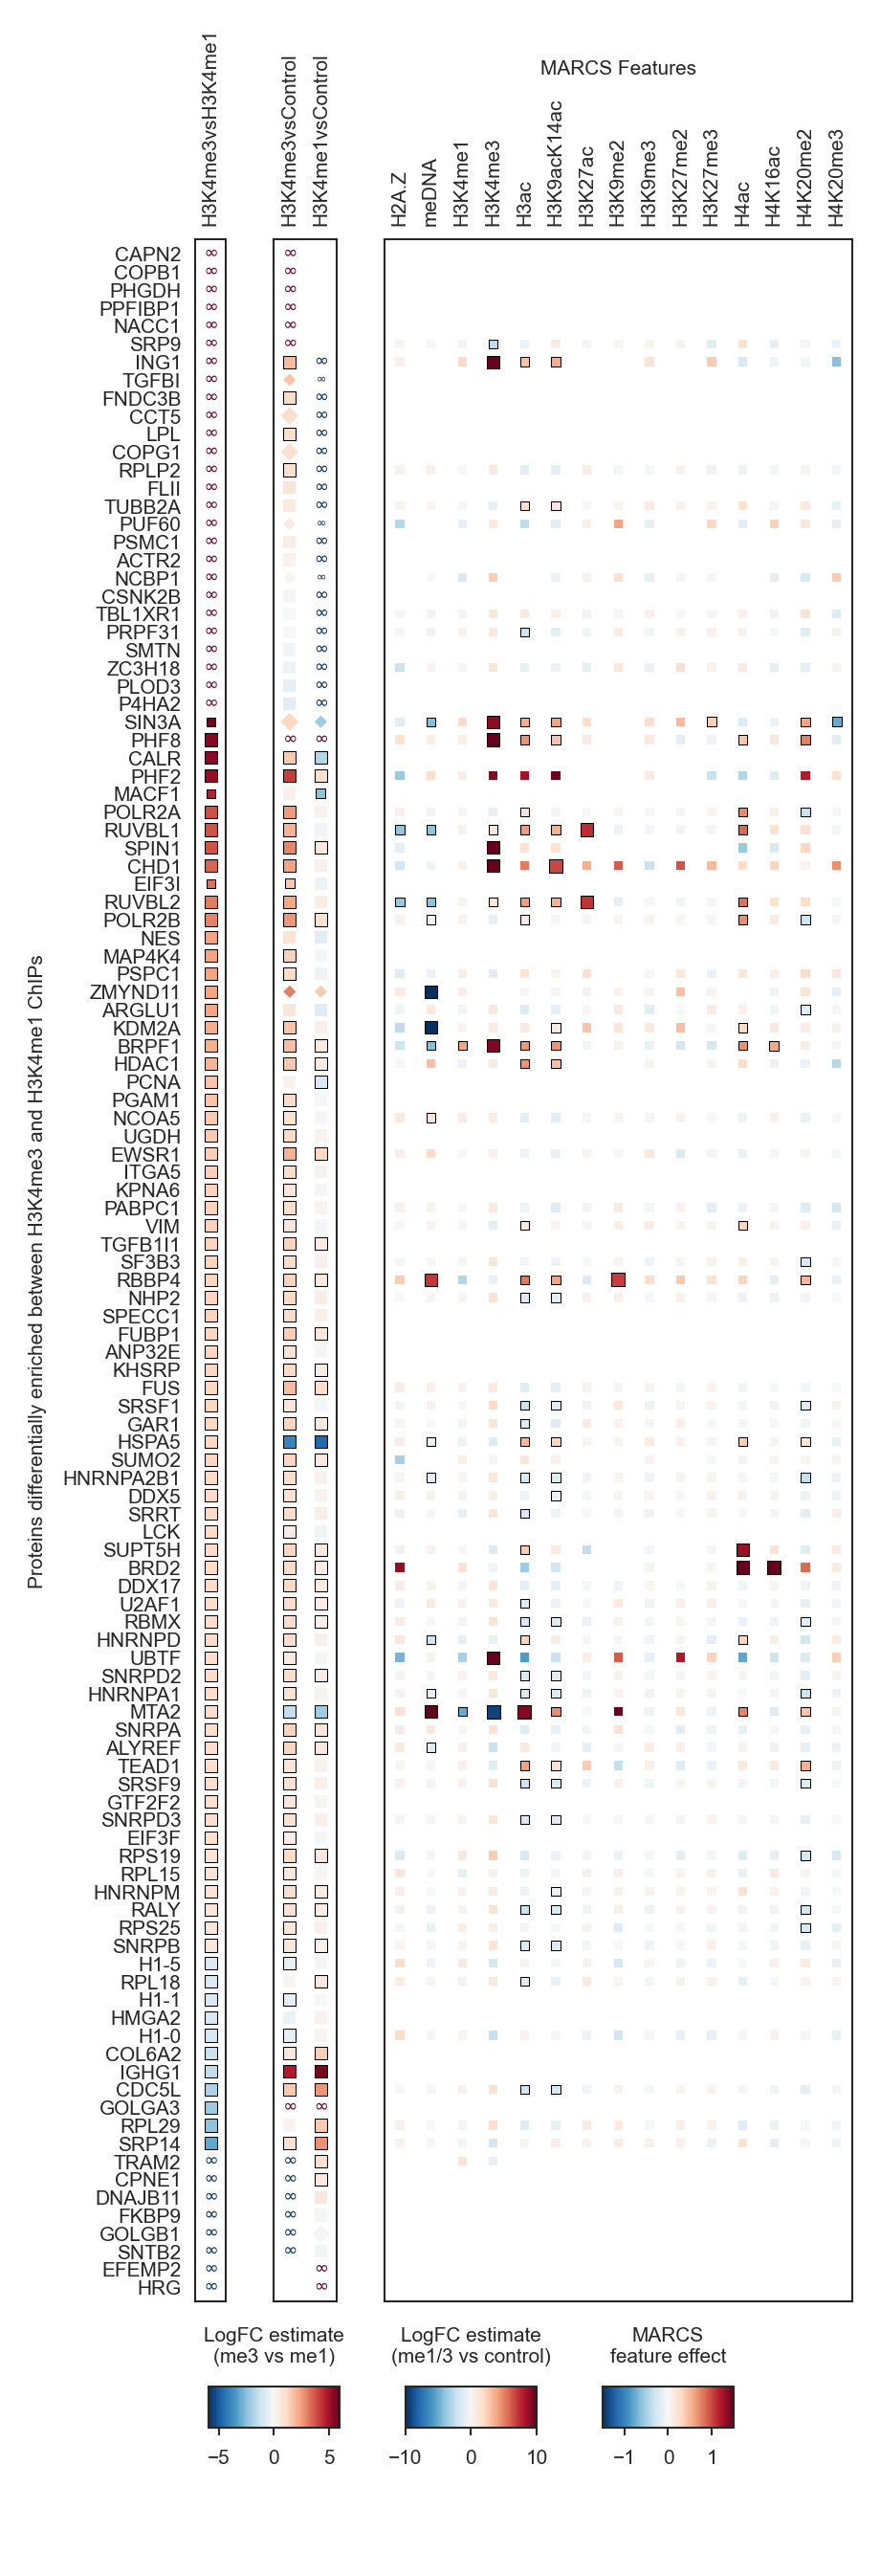

In [28]:
from matplotlib.gridspec import GridSpec
figure = plt.figure(figsize=(15*FIVE_MM_IN_INCH, 45*FIVE_MM_IN_INCH), constrained_layout=True)

gs = GridSpec(2, 3, figure=figure, width_ratios=(1, 2, 15), height_ratios=(10,1))
ax_legends = figure.add_subplot(gs[1,:])
ax_legends.axis('off')

cax_left = ax_legends.inset_axes([0.02, 0.58, 0.2, 0.2], transform=ax_legends.transAxes)
cax_left.grid(False)
cax_left2 = ax_legends.inset_axes([0.32, 0.58, 0.2, 0.2], transform=ax_legends.transAxes)
cax_left2.grid(False)
cax_right = ax_legends.inset_axes([0.62, 0.58, 0.2, 0.2], transform=ax_legends.transAxes)
cax_right.grid(False)

cax_left.set_title(f"LogFC estimate\n(me3 vs me1)")
cax_left2.set_title("LogFC estimate\n(me1/3 vs control)")
cax_right.set_title("MARCS\nfeature effect")

ax_left  = figure.add_subplot(gs[0, 0])
ax_left2 = figure.add_subplot(gs[0, 1], sharey=ax_left)
ax_right = figure.add_subplot(gs[0, 2], sharey=ax_left)

# Heatmap for the coef (diff), left

cmap_coef = 'RdBu_r'
_df_coef = df.xs(coef, level='coef') 
vmax_coef = np.ceil(_df_coef['logFC_imputed'].abs().replace(np.inf, np.nan).dropna().max())
vmin_coef = -vmax_coef

for flags, _subdf in _df_coef.groupby(['significant', 'logFC_based_on_single_datapoint', 'logFC_is_imputed', 'logFC_is_infinite']):
    
    kwargs = decide_kwargs(*flags)
    
    colors_coef = ax_left.scatter(
        [1] * len(_subdf), 
        _subdf['row_coord'],
        c=_subdf['logFC_imputed'].replace(np.inf,vmax_coef).replace(-np.inf, vmin_coef),
        cmap='RdBu_r',
        vmin=vmin_coef,
        vmax=vmax_coef,
        **kwargs,
    )
    
fig.colorbar(colors_coef, ax=ax_legends, cax=cax_left, orientation='horizontal')

ax_left.set_yticks(row_coords, labels=row_coords.index)
ax_left.set_xticks([1], labels=[coef])
ax_left.set_ylabel("Proteins differentially enriched between H3K4me3 and H3K4me1 ChIPs")


# Heatmap for the other coefficients (left2)
cmap_other_coefs = 'RdBu_r'
vmax_other_coefs = np.ceil(df.loc(axis=0)[:, other_coefs]['logFC_imputed'].abs().replace(np.inf, np.nan).dropna().max())
vmin_other_coefs = -vmax_other_coefs

for i, other_coef in enumerate(other_coefs, start=1):
    _df_other_coef = df.xs(other_coef, level='coef') 
    
    for flags, _subdf in _df_other_coef.groupby(['significant', 'logFC_based_on_single_datapoint', 'logFC_is_imputed', 'logFC_is_infinite']):
    
        kwargs = decide_kwargs(*flags)

        colors_other_coef = ax_left2.scatter(
            [i] * len(_subdf), 
            _subdf['row_coord'],
            c=_subdf['logFC_imputed'].replace(np.inf,vmax_other_coefs).replace(-np.inf, vmin_other_coefs),
            cmap='RdBu_r',
            vmin=vmin_other_coefs,
            vmax=vmax_other_coefs,
            **kwargs,
        )

fig.colorbar(colors_other_coef, ax=ax_legends, cax=cax_left2, orientation='horizontal')

ax_left2.set_xticks(np.arange(1, len(other_coefs)+1), labels=other_coefs)
ax_left2.set_xlim(0.5, 2.5)


# Heatmap for MARCS FEATURES
cmap_marcs = 'RdBu_r'
vmax_marcs = 1.5
vmin_marcs = -1.5

for i, marcs_feature in enumerate(MARCS_FEATURE_ORDER, start=1):
    _df_feature = df_marcs_features.xs(marcs_feature, level='marcs_feature') 
    
    for flags, _subdf in _df_feature.groupby(['significant', 'significant_category_strong']):
    
        kwargs = decide_kwargs_marcs(*flags)

        colors_feature = ax_right.scatter(
            [i] * len(_subdf), 
            _subdf['row_coord'],
            c=_subdf['Effect'],
            cmap='RdBu_r',
            vmin=vmin_marcs,
            vmax=vmax_marcs,
            **kwargs,
        )

fig.colorbar(colors_feature, ax=ax_legends, cax=cax_right, orientation='horizontal')

ax_right.set_xticks(np.arange(1, len(MARCS_FEATURE_ORDER)+1), labels=MARCS_FEATURE_ORDER)
ax_right.set_xlim(0.5, len(MARCS_FEATURE_ORDER)+.5)
ax_right.set_title("MARCS Features")

for ax in [ax_left, ax_left2, ax_right]:
    
    ax.grid(False)
    ax.yaxis.set_tick_params(length=0)
    ax.set_ylim(row_coords.min() - 0.8, row_coords.max()+0.8)
    ax.xaxis.tick_top()
    ax.xaxis.set_tick_params(length=0, rotation=90)
    
    for spine in ax.spines:
        ax.spines[spine].set_visible(True)
        
for ax in [ax_left2, ax_right]:
    for tick in ax.yaxis.get_ticklabels():
        tick.set_visible(False)

_fname = OUTPUT_DIRECTORY / f'03-differential-proteins-vs-marcs.pdf'
_caption = f"""

Heatmap of all proteins with significantly different enrichments to H3K4me3 and H3K4me1 ChIP (-MS),
as well as for proteins with infinitely large differences between H3K4me3 and H3K4me1 which are based on more than one data point.

The first panel plots the estimate of the differential effect between H3K4me3 and H3K4me1, in descending order.
Red colour (positive values) indicates preference to H3K4me3, while blue colour indicates preference to H3K4me1.
Smaller markers indicate estimates which have only one datapoint in one of the conditions.
Proteins markedwith an infinity symbol have infinite enrichments (as they were not detected in one of the conditions being compared).
The colour scale limits are +/- {vmax_coef}. 

The second panel plots the estimates for the respective enrichments against control (H3 & H4) ChIPs.
Red colour indicates positive fold change (enrichment), blue colour indicates depletion.
Black border around the markers indicates statistical significance.
Diamond shaped values indicate "imputed" estimates in cases where model failed to generate one.
One special case of such estimates is the case where protein was detected in ChIP of me1/3, but not
the control ChIPs. Such cases are marked with infinity symbols as they represent infinite enrichments.

The rightmost panel lists MARCS feature breakdown and their corresponding effects.
Red colour indicates positive effeects (Recruitments), while blue colour highlights exclusions.
Black border indicates significant effects. Larger squares highlight "strong" enrichments.

"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)



### MARCS feature centred

The idea here is to make a similar plot like above, but center the focus on MARCS features,
that is sort proteins by the response to this feature.

We will do this for the features visible in the MWU heatmap above



    Heatmap of all proteins with significant feeature effects for H3K4me3.
    Proteins are sorted by this effect, in descending order.

    The first panel plots the estimate of the differential effect between H3K4me3 and H3K4me1.
    Red colour (positive values) indicates preference to H3K4me3, while blue colour indicates preference to H3K4me1.
    Smaller markers indicate estimates which have only one datapoint in one of the conditions.
    Proteins markedwith an infinity symbol have infinite enrichments (as they were not detected in one of the conditions being compared).
    The colour scale limits are +/- 6.0. 

    The second panel plots the estimates for the respective enrichments against control (H3 & H4) ChIPs.
    Red colour indicates positive fold change (enrichment), blue colour indicates depletion.
    Black border around the markers indicates statistical significance.
    Diamond shaped values indicate "imputed" estimates in cases where model failed to generate one.
   

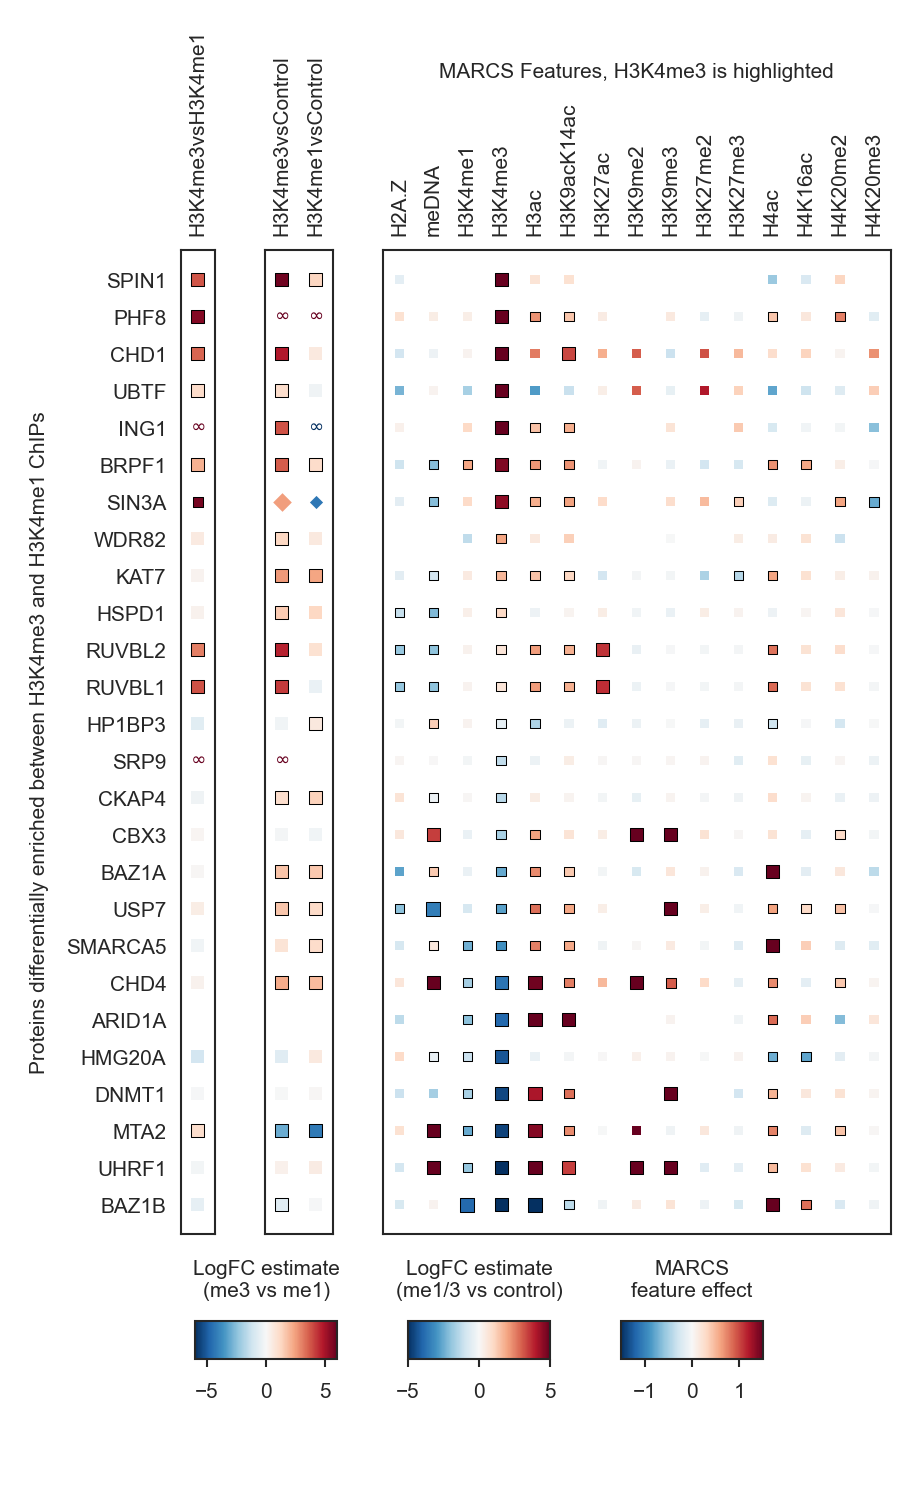

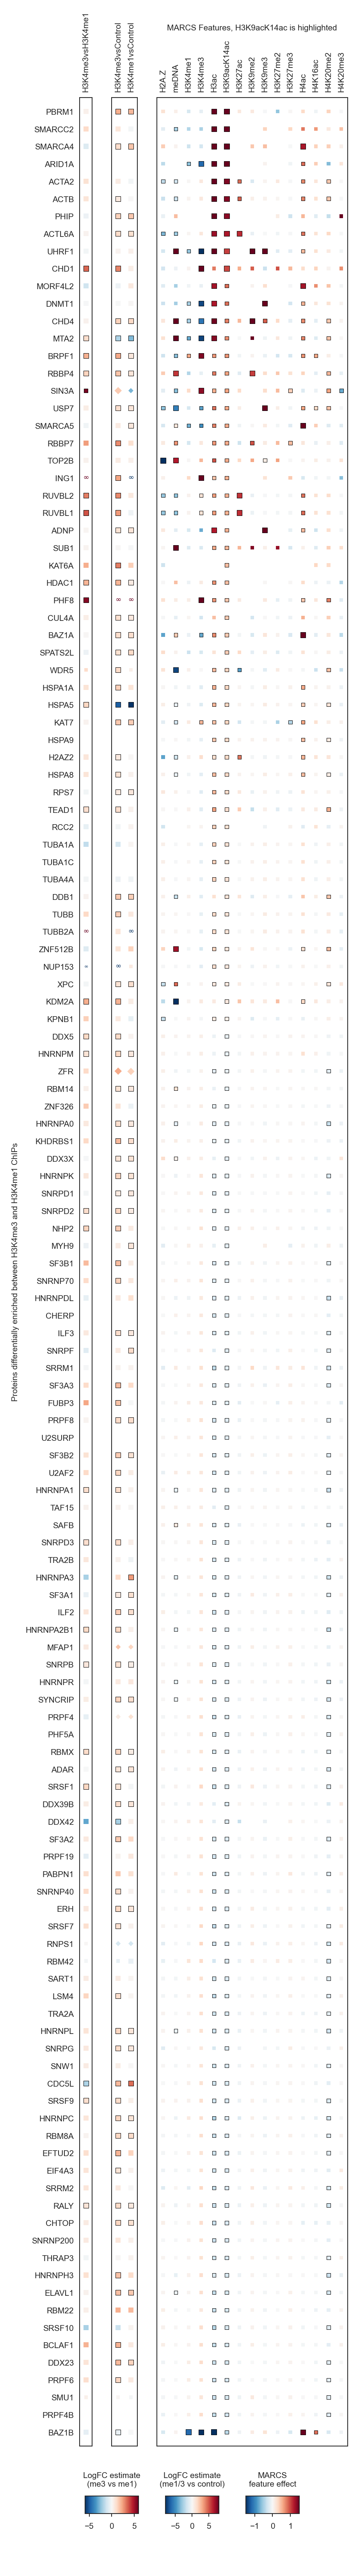

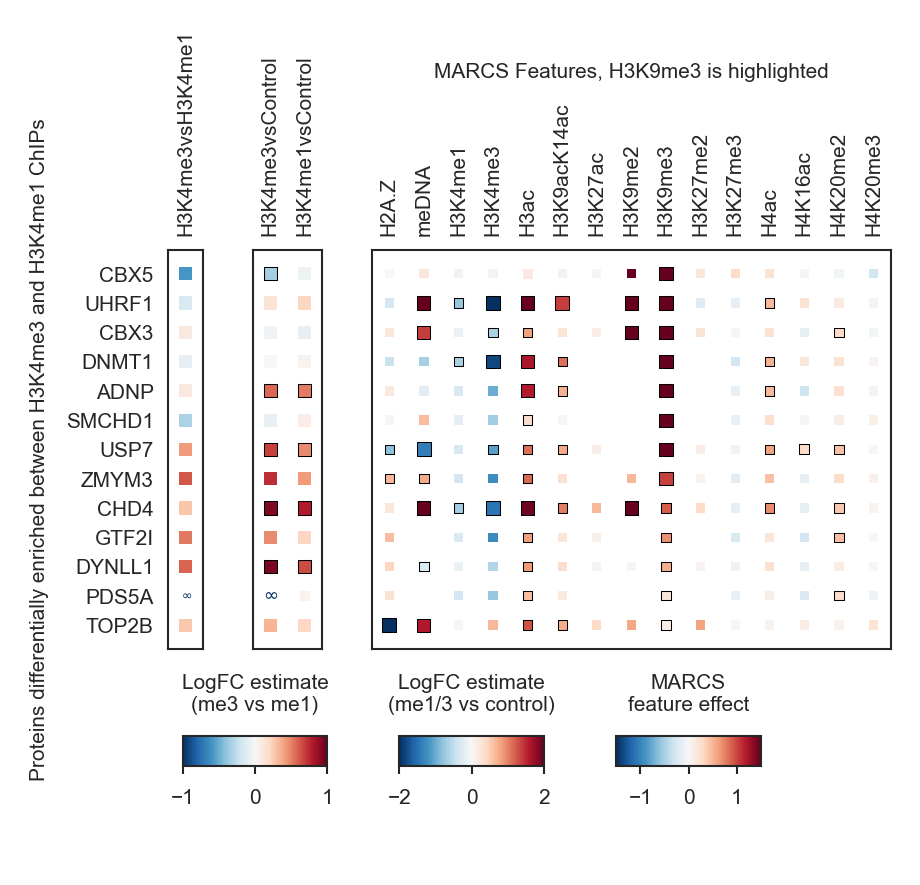

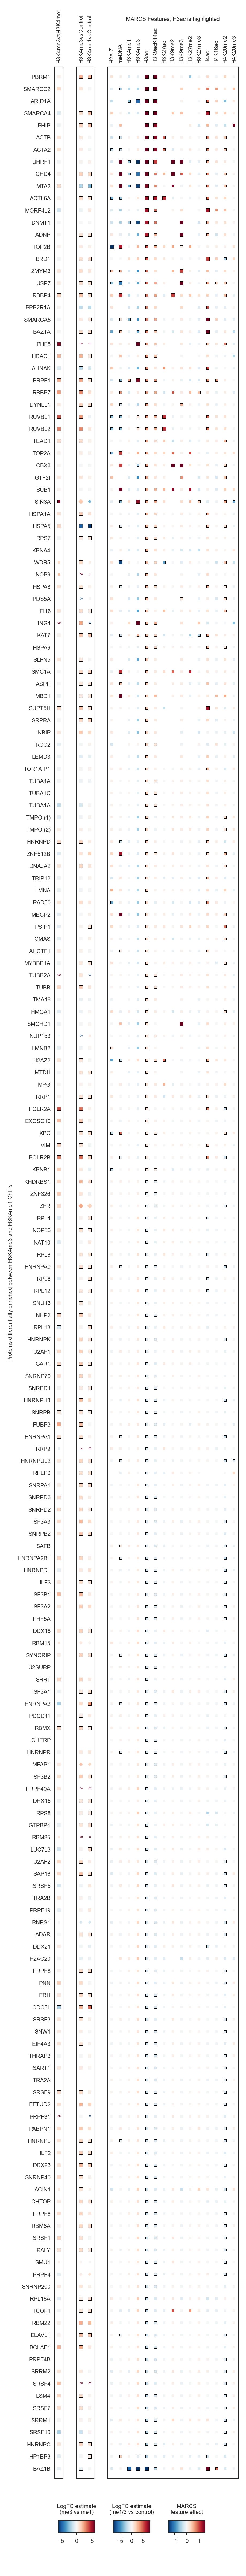

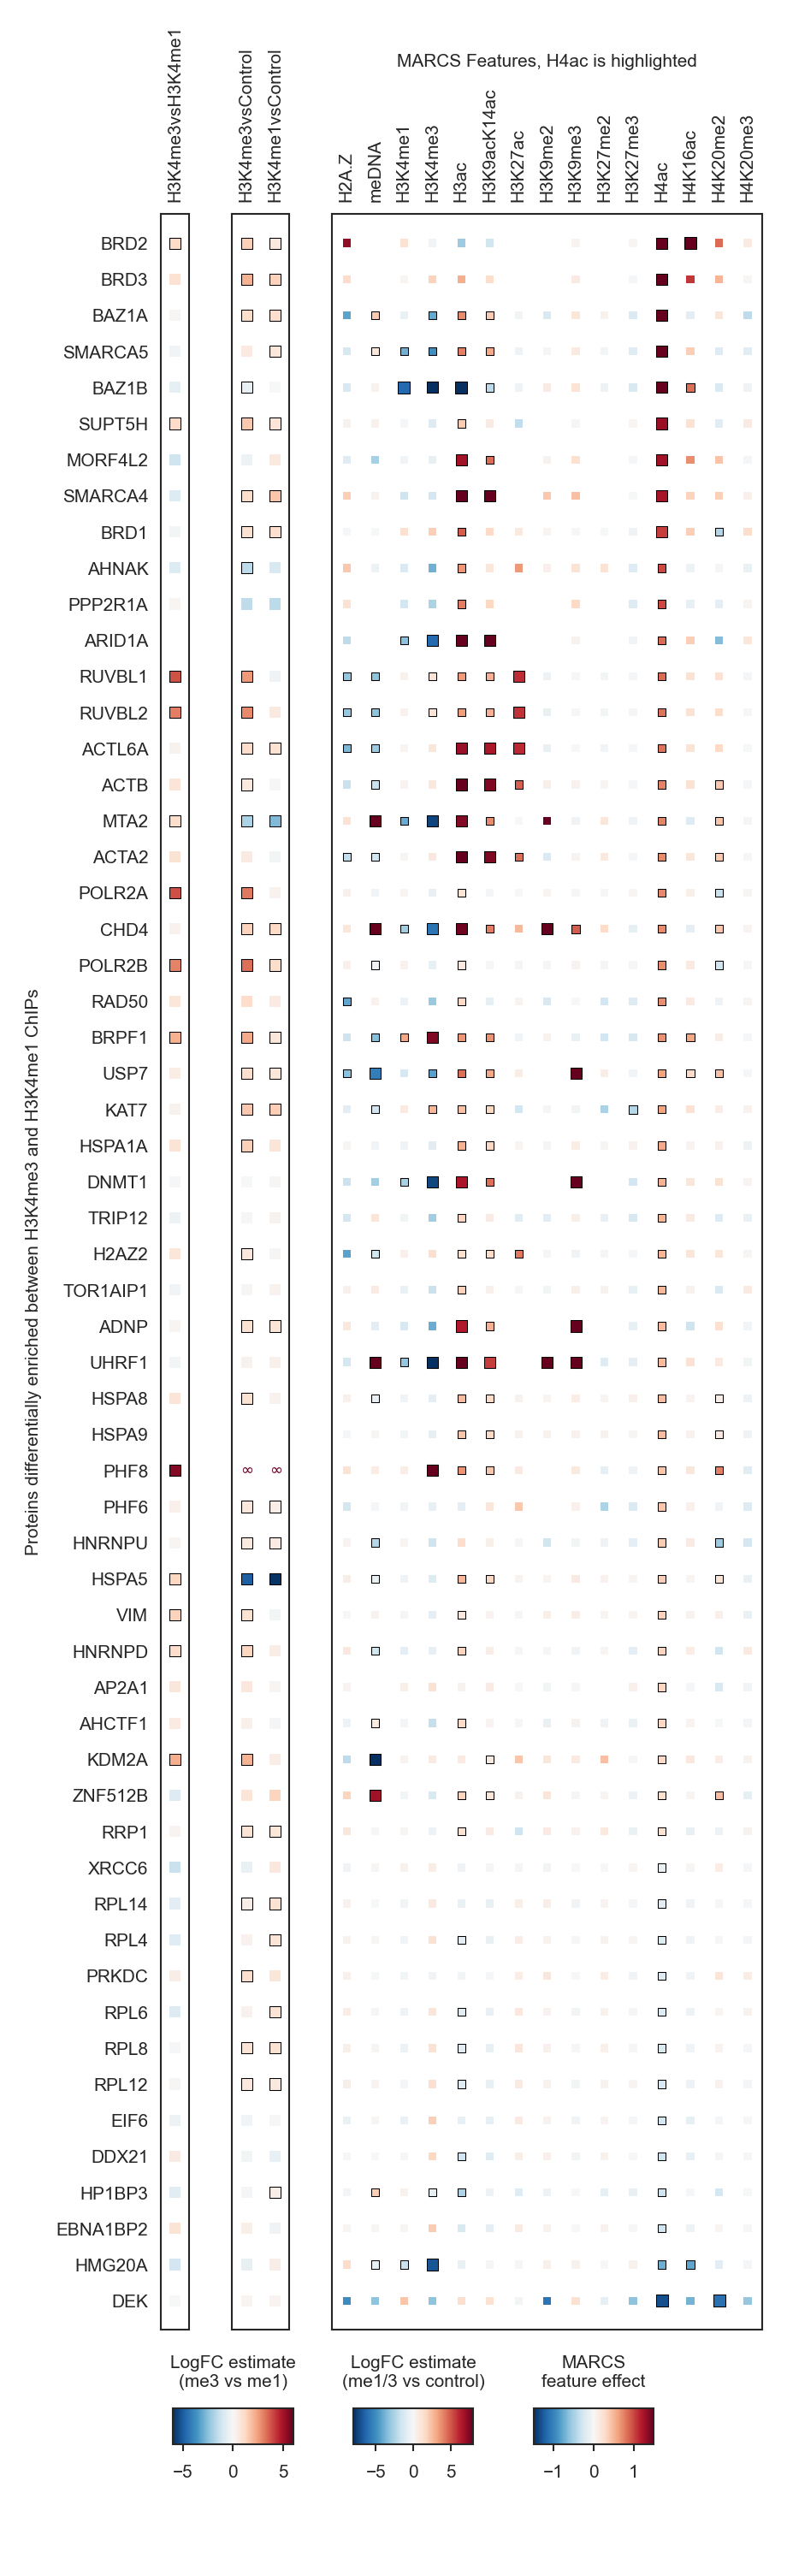

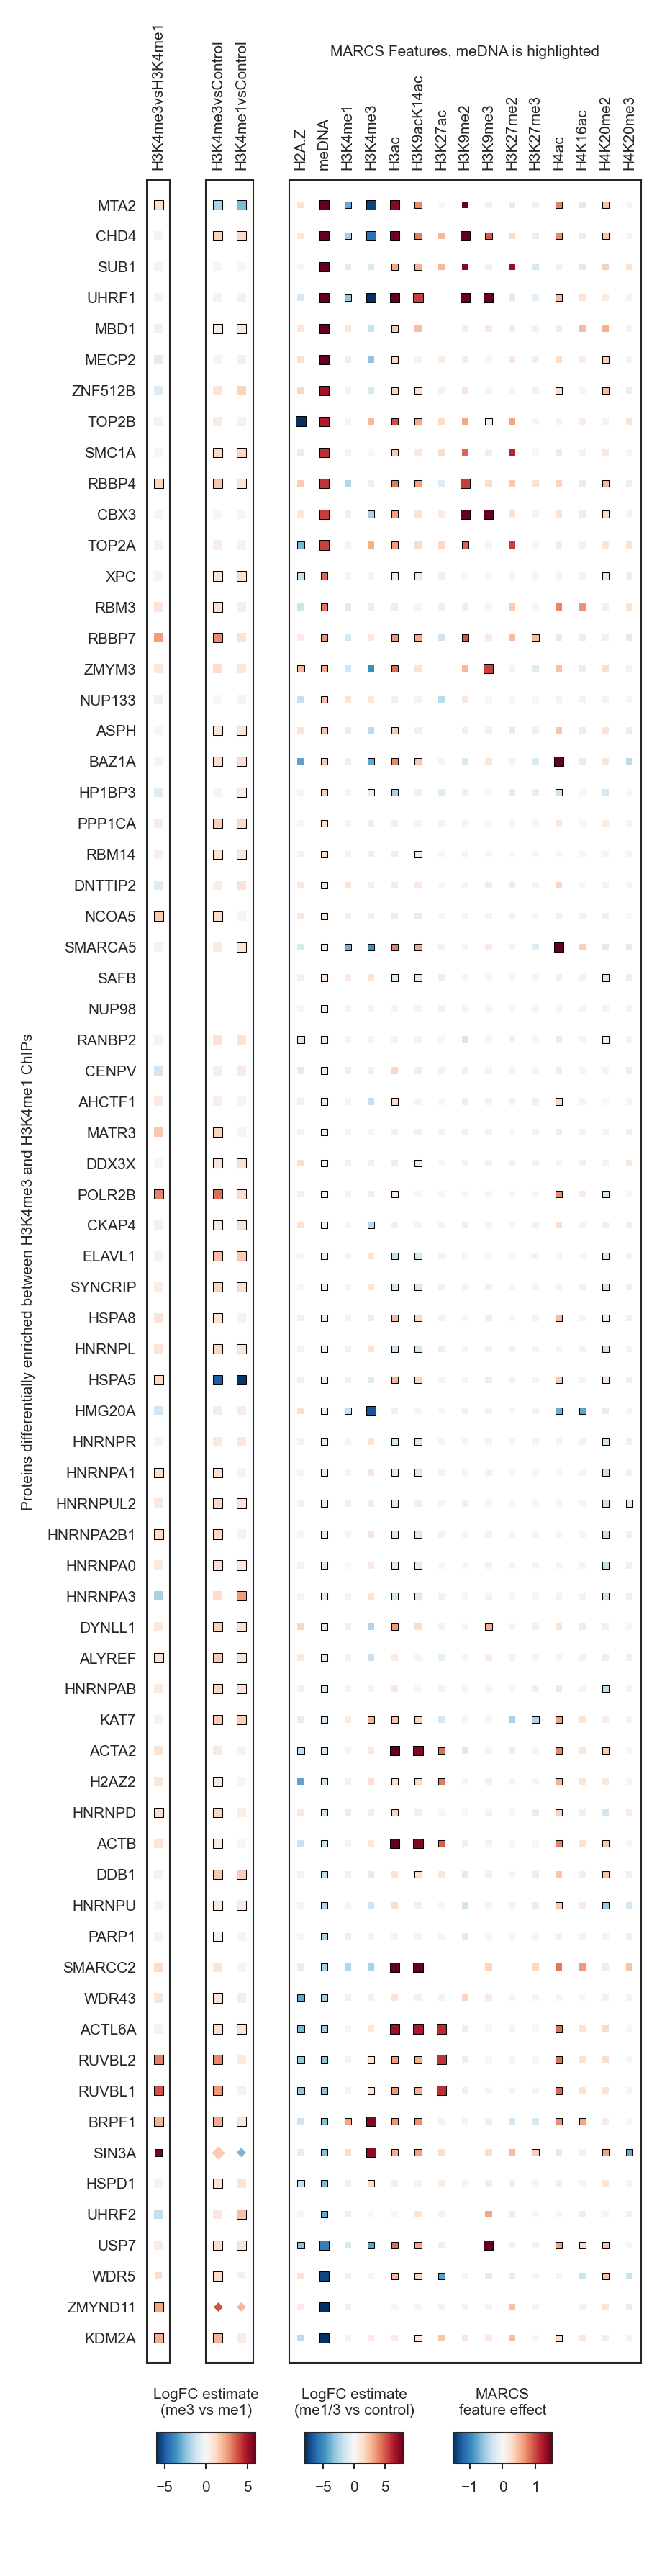

In [29]:
# Only work with featureas that were estimable in the MWU heatmap (see above)
_features = results_mwu.groupby('marcs_feature')['p-val'].apply(lambda x: (~x.isnull()).any())
_features = _features[_features].index

for marcs_feature_of_interest in _features:

    coef = 'H3K4me3vsH3K4me1'
    other_coefs = ['H3K4me3vsControl', 'H3K4me1vsControl']

    # Take all proteins that are significant in this feature response as "Interesting"
    mask_interesting = data_marcs_features['significant', marcs_feature_of_interest].fillna(False)
    interesting_proteins = mask_interesting[mask_interesting].index
    # Sort by effect
    interesting_proteins = data_marcs_features.loc[interesting_proteins, ('Effect', marcs_feature_of_interest)].sort_values(ascending=False).index
    # Make the label the same as model results so pandas does not complain
    interesting_proteins.name = 'Label'

    # Extract coefficients for the interesting proteins
    matrix_diff_fold_change = data_model_outputs.loc[interesting_proteins, (coef, 'logFC_imputed')]

    # We can now assign the row coordinates for them
    row_coords = pd.Series(list(reversed(np.arange(1, len(interesting_proteins) + 1))), index=interesting_proteins, name='row_coord')

    # Extract the model's matrix in long format
    df = data_model_outputs[MODEL_COEFS].loc[interesting_proteins].stack(level=0, dropna=False)
    df.index.names = ['Label', 'coef']

    # Check that we got all proteins, in the correct order
    assert list(interesting_proteins) == list(df.index.get_level_values('Label').unique())

    # Add an extra column
    df['logFC_is_infinite'] = (~pd.isnull(df['logFC_imputed'])) & (~np.isfinite(df['logFC_imputed']))
    # And add the row coordinate
    df = df.join(row_coords)
    
    # Also create MARCS feature DF
    
    df_marcs_features = data_marcs_features[['Effect', 'significant', 'significant_category_strong']].stack(level='marcs_feature')
    df_marcs_features = df_marcs_features.join(row_coords, on='chip_ms_label').dropna(subset=['row_coord'])
    
    
    # Do the heatmap
    
    from matplotlib.gridspec import GridSpec
    figure = plt.figure(figsize=(15*FIVE_MM_IN_INCH, (len(interesting_proteins)*0.8*FIVE_MM_IN_INCH + 4*FIVE_MM_IN_INCH)), constrained_layout=True)

    gs = GridSpec(2, 3, figure=figure, width_ratios=(1, 2, 15), height_ratios=(len(interesting_proteins),5))
    ax_legends = figure.add_subplot(gs[1,:])
    ax_legends.axis('off')

    cax_left = ax_legends.inset_axes([0.02, 0.58, 0.2, 0.2], transform=ax_legends.transAxes)
    cax_left.grid(False)
    cax_left2 = ax_legends.inset_axes([0.32, 0.58, 0.2, 0.2], transform=ax_legends.transAxes)
    cax_left2.grid(False)
    cax_right = ax_legends.inset_axes([0.62, 0.58, 0.2, 0.2], transform=ax_legends.transAxes)
    cax_right.grid(False)

    cax_left.set_title(f"LogFC estimate\n(me3 vs me1)")
    cax_left2.set_title("LogFC estimate\n(me1/3 vs control)")
    cax_right.set_title("MARCS\nfeature effect")

    ax_left  = figure.add_subplot(gs[0, 0])
    ax_left2 = figure.add_subplot(gs[0, 1], sharey=ax_left)
    ax_right = figure.add_subplot(gs[0, 2], sharey=ax_left)

    # Heatmap for the coef (diff), left

    cmap_coef = 'RdBu_r'
    _df_coef = df.xs(coef, level='coef') 
    vmax_coef = np.ceil(_df_coef['logFC_imputed'].abs().replace(np.inf, np.nan).dropna().max())
    vmin_coef = -vmax_coef

    for flags, _subdf in _df_coef.groupby(['significant', 'logFC_based_on_single_datapoint', 'logFC_is_imputed', 'logFC_is_infinite']):

        kwargs = decide_kwargs(*flags)

        colors_coef = ax_left.scatter(
            [1] * len(_subdf), 
            _subdf['row_coord'],
            c=_subdf['logFC_imputed'].replace(np.inf,vmax_coef).replace(-np.inf, vmin_coef),
            cmap='RdBu_r',
            vmin=vmin_coef,
            vmax=vmax_coef,
            **kwargs,
        )

    fig.colorbar(colors_coef, ax=ax_legends, cax=cax_left, orientation='horizontal')

    ax_left.set_yticks(row_coords, labels=row_coords.index)
    ax_left.set_xticks([1], labels=[coef])
    ax_left.set_ylabel("Proteins differentially enriched between H3K4me3 and H3K4me1 ChIPs")


    # Heatmap for the other coefficients (left2)
    cmap_other_coefs = 'RdBu_r'
    vmax_other_coefs = np.ceil(df.loc(axis=0)[:, other_coefs]['logFC_imputed'].abs().replace(np.inf, np.nan).dropna().max())
    vmin_other_coefs = -vmax_other_coefs

    for i, other_coef in enumerate(other_coefs, start=1):
        _df_other_coef = df.xs(other_coef, level='coef') 

        for flags, _subdf in _df_other_coef.groupby(['significant', 'logFC_based_on_single_datapoint', 'logFC_is_imputed', 'logFC_is_infinite']):

            kwargs = decide_kwargs(*flags)

            colors_other_coef = ax_left2.scatter(
                [i] * len(_subdf), 
                _subdf['row_coord'],
                c=_subdf['logFC_imputed'].replace(np.inf,vmax_other_coefs).replace(-np.inf, vmin_other_coefs),
                cmap='RdBu_r',
                vmin=vmin_other_coefs,
                vmax=vmax_other_coefs,
                **kwargs,
            )

    fig.colorbar(colors_other_coef, ax=ax_legends, cax=cax_left2, orientation='horizontal')

    ax_left2.set_xticks(np.arange(1, len(other_coefs)+1), labels=other_coefs)
    ax_left2.set_xlim(0.5, 2.5)


    # Heatmap for MARCS FEATURES
    cmap_marcs = 'RdBu_r'
    vmax_marcs = 1.5
    vmin_marcs = -1.5

    for i, marcs_feature in enumerate(MARCS_FEATURE_ORDER, start=1):
        _df_feature = df_marcs_features.xs(marcs_feature, level='marcs_feature') 

        for flags, _subdf in _df_feature.groupby(['significant', 'significant_category_strong']):

            kwargs = decide_kwargs_marcs(*flags)

            colors_feature = ax_right.scatter(
                [i] * len(_subdf), 
                _subdf['row_coord'],
                c=_subdf['Effect'],
                cmap='RdBu_r',
                vmin=vmin_marcs,
                vmax=vmax_marcs,
                **kwargs,
            )

    fig.colorbar(colors_feature, ax=ax_legends, cax=cax_right, orientation='horizontal')

    ax_right.set_xticks(np.arange(1, len(MARCS_FEATURE_ORDER)+1), labels=MARCS_FEATURE_ORDER)
    ax_right.set_xlim(0.5, len(MARCS_FEATURE_ORDER)+.5)
    ax_right.set_title(f"MARCS Features, {marcs_feature_of_interest} is highlighted")

    for ax in [ax_left, ax_left2, ax_right]:

        ax.grid(False)
        ax.yaxis.set_tick_params(length=0)
        ax.set_ylim(row_coords.min() - 0.8, row_coords.max()+0.8)
        ax.xaxis.tick_top()
        ax.xaxis.set_tick_params(length=0, rotation=90)

        for spine in ax.spines:
            ax.spines[spine].set_visible(True)

    for ax in [ax_left2, ax_right]:
        for tick in ax.yaxis.get_ticklabels():
            tick.set_visible(False)

    _fname = OUTPUT_DIRECTORY / f'04-marcs-{marcs_feature_of_interest}-vs-chip-ms.pdf'
    _caption = f"""

    Heatmap of all proteins with significant feeature effects for {marcs_feature_of_interest}.
    Proteins are sorted by this effect, in descending order.

    The first panel plots the estimate of the differential effect between H3K4me3 and H3K4me1.
    Red colour (positive values) indicates preference to H3K4me3, while blue colour indicates preference to H3K4me1.
    Smaller markers indicate estimates which have only one datapoint in one of the conditions.
    Proteins markedwith an infinity symbol have infinite enrichments (as they were not detected in one of the conditions being compared).
    The colour scale limits are +/- {vmax_coef}. 

    The second panel plots the estimates for the respective enrichments against control (H3 & H4) ChIPs.
    Red colour indicates positive fold change (enrichment), blue colour indicates depletion.
    Black border around the markers indicates statistical significance.
    Diamond shaped values indicate "imputed" estimates in cases where model failed to generate one.
    One special case of such estimates is the case where protein was detected in ChIP of me1/3, but not
    the control ChIPs. Such cases are marked with infinity symbols as they represent infinite enrichments.

    The rightmost panel lists MARCS feature breakdown and their corresponding effects.
    Red colour indicates positive effeects (Recruitments), while blue colour highlights exclusions.
    Black border indicates significant effects. Larger squares highlight "strong" enrichments.

    """
    plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
    with open(str(_fname) + '.caption.md', 'w') as f:
        f.write(_caption)
        print(_caption)
   

## Scatterplots

We finally create a set of summary scatterplots plots that highlights the model outputs in together with the MARCS feature overlays.

For this we will need the coefficient estimates from the model, as well as the classifications from the selected MARCS feature

In [30]:
PALETTE = {
    'Background': '#bdbdbd',
    'Strongly recruited': '#BA5047',
    'Strongly excluded': '#4B82B6',
    'Controls': '#5e5e5e'
}

PALETTE_TEXT = {
    'Background': 'black',
    'Strongly recruited': '#BA5047',
    'Strongly excluded': '#4B82B6',
    'Controls': 'black'
}


PALETTE_EDGES = {
    'background': '#CDCDCD',
    'highlight': '#525252'
}

EDGEWIDTH = 0.35
ALPHA = 0.8

MARKERSIZES = {
    'large': 8,
    'small': 4,
}

AXIS_LINECOLOR = '#969696'

/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(




Scaterplots of all proteins with ChIP-MS model outputs.
On the X axis, the imputed estimate of H3K4me3vsControl log2 fold change is plotted.
On the Y axis, the imputed estimate of H3K4me1vsControl log2 fold change is plotted.

Each marker corresponds to a protein in ChIP-MS data, for which we have such estimates.

The darker border around certain markers indicates that the H3K4me3vsH3K4me1 difference is statistically significant.
Smaller markers indicate that one of the three estimates (me1/3 vs Control, or me3 vs me1) was imputed or is based on a single datapoint. 

Histone proteins are highlighted in dark grey.
And the proteins strongly recruited to MARCS feature H3K4me3 are highlighted in red.
Proteins strongly excluded from MARCS feature H3K4me3 are highlighted in blue.

The labels are placed on out-of-bounds proteins that are significantly different me3 vs me1, 
on proteins in MARCS feature categories, and on a small selection of other significantly differential me3 vs me1 prote

/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(




Scaterplots of all proteins with ChIP-MS model outputs.
On the X axis, the imputed estimate of H3K4me3vsControl log2 fold change is plotted.
On the Y axis, the imputed estimate of H3K4me1vsControl log2 fold change is plotted.

Each marker corresponds to a protein in ChIP-MS data, for which we have such estimates.

The darker border around certain markers indicates that the H3K4me3vsH3K4me1 difference is statistically significant.
Smaller markers indicate that one of the three estimates (me1/3 vs Control, or me3 vs me1) was imputed or is based on a single datapoint. 

Histone proteins are highlighted in dark grey.
And the proteins strongly recruited to MARCS feature H3K9acK14ac are highlighted in red.
Proteins strongly excluded from MARCS feature H3K9acK14ac are highlighted in blue.

The labels are placed on out-of-bounds proteins that are significantly different me3 vs me1, 
on proteins in MARCS feature categories, and on a small selection of other significantly differential me3 vs m

/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(




Scaterplots of all proteins with ChIP-MS model outputs.
On the X axis, the imputed estimate of H3K4me3vsControl log2 fold change is plotted.
On the Y axis, the imputed estimate of H3K4me1vsControl log2 fold change is plotted.

Each marker corresponds to a protein in ChIP-MS data, for which we have such estimates.

The darker border around certain markers indicates that the H3K4me3vsH3K4me1 difference is statistically significant.
Smaller markers indicate that one of the three estimates (me1/3 vs Control, or me3 vs me1) was imputed or is based on a single datapoint. 

Histone proteins are highlighted in dark grey.
And the proteins strongly recruited to MARCS feature H3K9me3 are highlighted in red.
Proteins strongly excluded from MARCS feature H3K9me3 are highlighted in blue.

The labels are placed on out-of-bounds proteins that are significantly different me3 vs me1, 
on proteins in MARCS feature categories, and on a small selection of other significantly differential me3 vs me1 prote

/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(




Scaterplots of all proteins with ChIP-MS model outputs.
On the X axis, the imputed estimate of H3K4me3vsControl log2 fold change is plotted.
On the Y axis, the imputed estimate of H3K4me1vsControl log2 fold change is plotted.

Each marker corresponds to a protein in ChIP-MS data, for which we have such estimates.

The darker border around certain markers indicates that the H3K4me3vsH3K4me1 difference is statistically significant.
Smaller markers indicate that one of the three estimates (me1/3 vs Control, or me3 vs me1) was imputed or is based on a single datapoint. 

Histone proteins are highlighted in dark grey.
And the proteins strongly recruited to MARCS feature H3ac are highlighted in red.
Proteins strongly excluded from MARCS feature H3ac are highlighted in blue.

The labels are placed on out-of-bounds proteins that are significantly different me3 vs me1, 
on proteins in MARCS feature categories, and on a small selection of other significantly differential me3 vs me1 proteins.



/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(




Scaterplots of all proteins with ChIP-MS model outputs.
On the X axis, the imputed estimate of H3K4me3vsControl log2 fold change is plotted.
On the Y axis, the imputed estimate of H3K4me1vsControl log2 fold change is plotted.

Each marker corresponds to a protein in ChIP-MS data, for which we have such estimates.

The darker border around certain markers indicates that the H3K4me3vsH3K4me1 difference is statistically significant.
Smaller markers indicate that one of the three estimates (me1/3 vs Control, or me3 vs me1) was imputed or is based on a single datapoint. 

Histone proteins are highlighted in dark grey.
And the proteins strongly recruited to MARCS feature H4ac are highlighted in red.
Proteins strongly excluded from MARCS feature H4ac are highlighted in blue.

The labels are placed on out-of-bounds proteins that are significantly different me3 vs me1, 
on proteins in MARCS feature categories, and on a small selection of other significantly differential me3 vs me1 proteins.



/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(




Scaterplots of all proteins with ChIP-MS model outputs.
On the X axis, the imputed estimate of H3K4me3vsControl log2 fold change is plotted.
On the Y axis, the imputed estimate of H3K4me1vsControl log2 fold change is plotted.

Each marker corresponds to a protein in ChIP-MS data, for which we have such estimates.

The darker border around certain markers indicates that the H3K4me3vsH3K4me1 difference is statistically significant.
Smaller markers indicate that one of the three estimates (me1/3 vs Control, or me3 vs me1) was imputed or is based on a single datapoint. 

Histone proteins are highlighted in dark grey.
And the proteins strongly recruited to MARCS feature meDNA are highlighted in red.
Proteins strongly excluded from MARCS feature meDNA are highlighted in blue.

The labels are placed on out-of-bounds proteins that are significantly different me3 vs me1, 
on proteins in MARCS feature categories, and on a small selection of other significantly differential me3 vs me1 proteins.

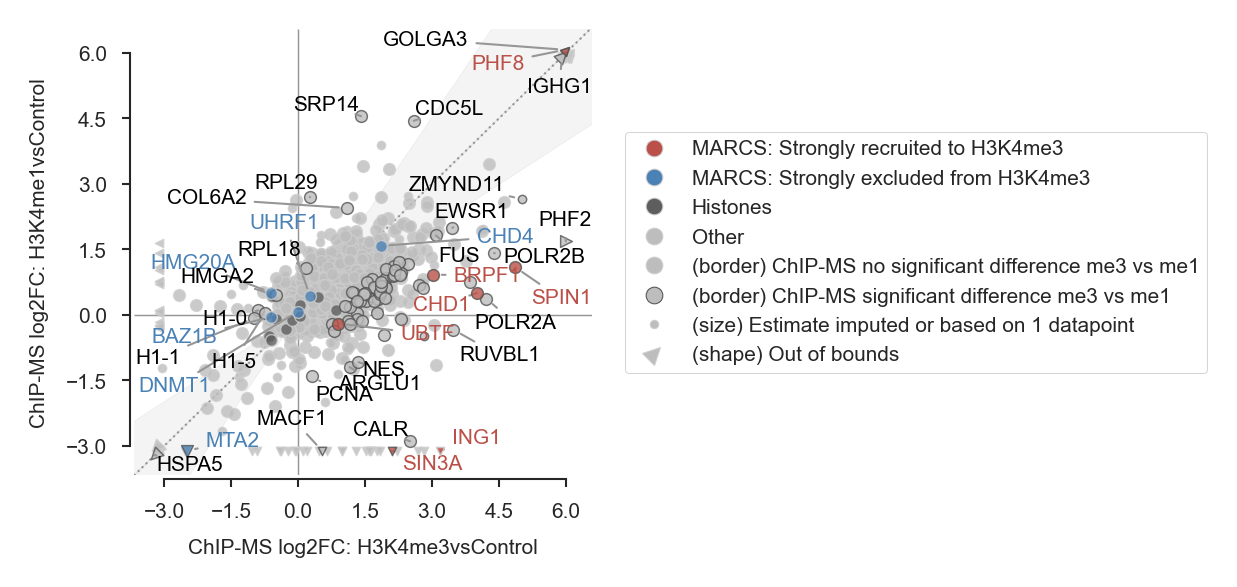

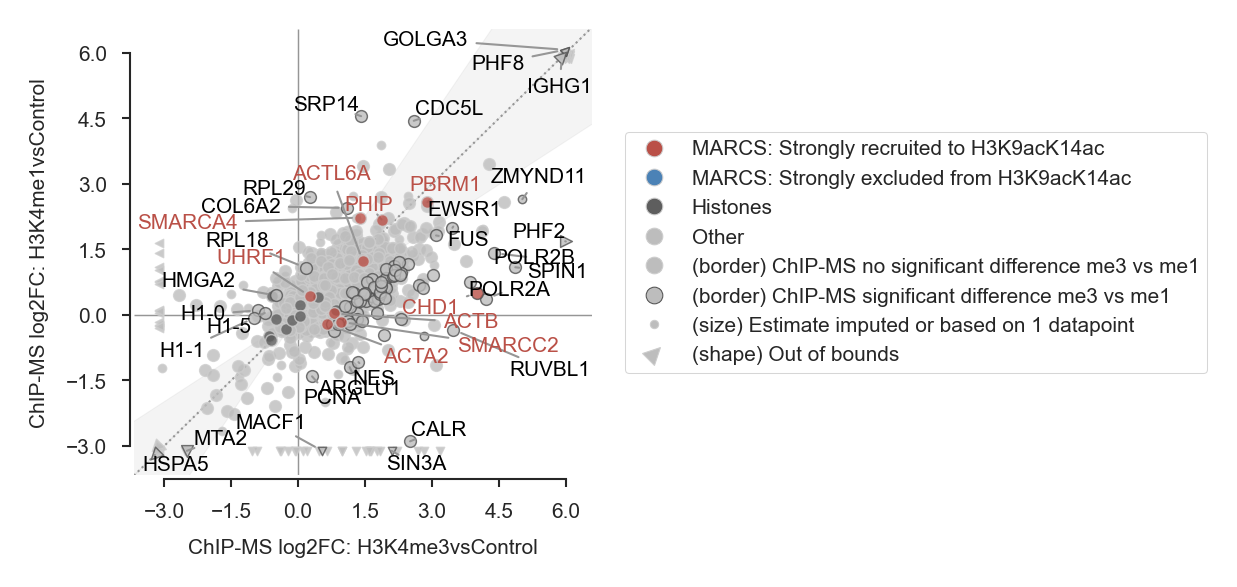

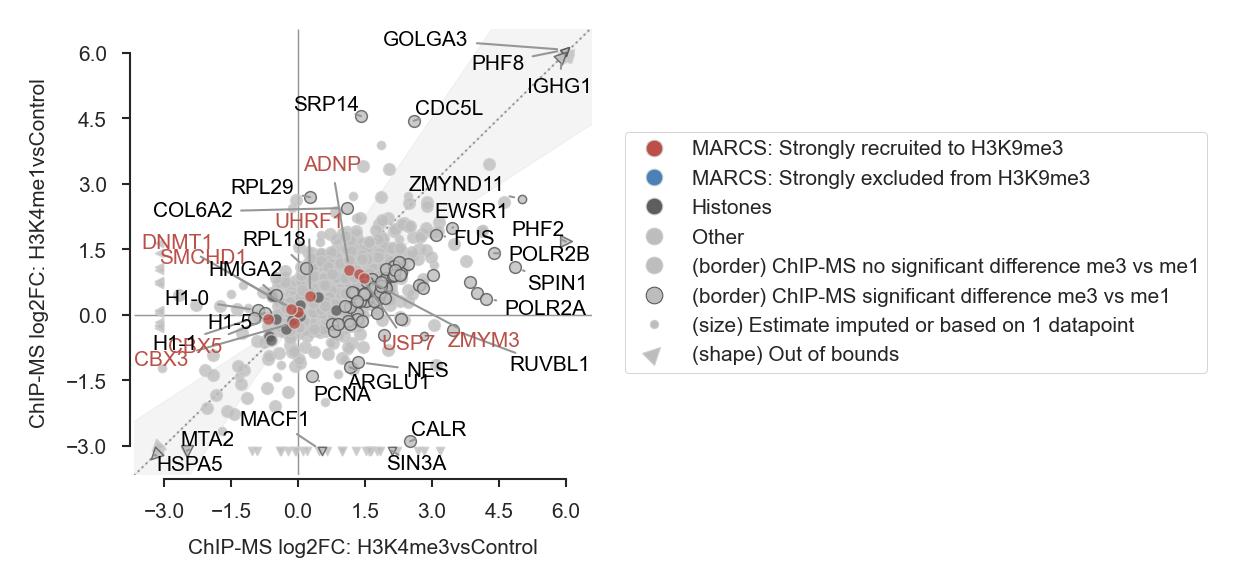

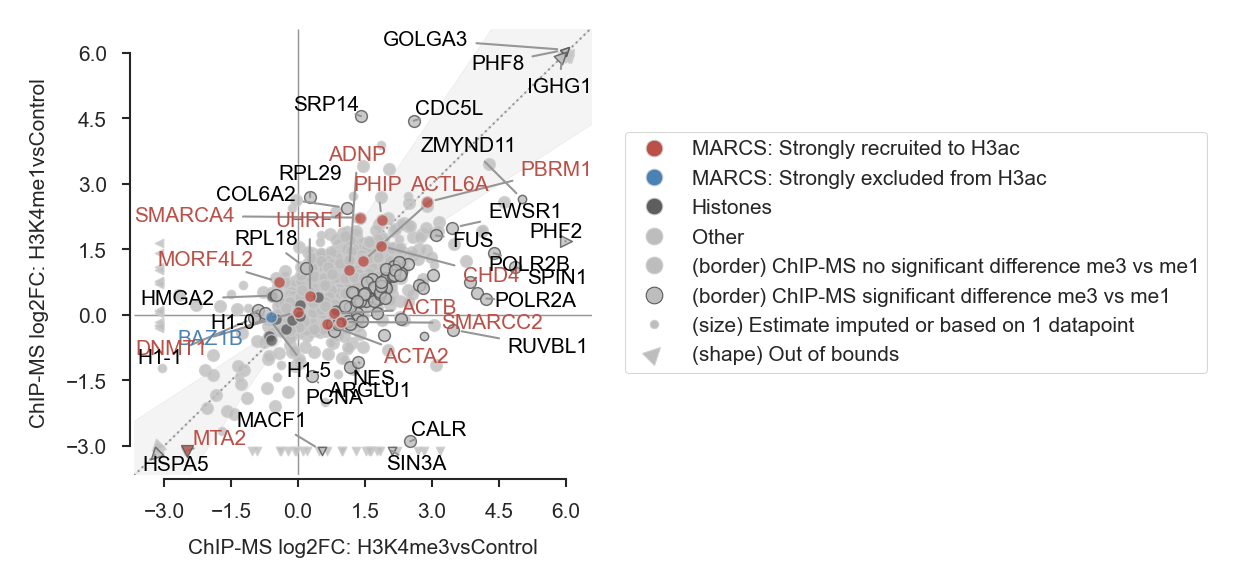

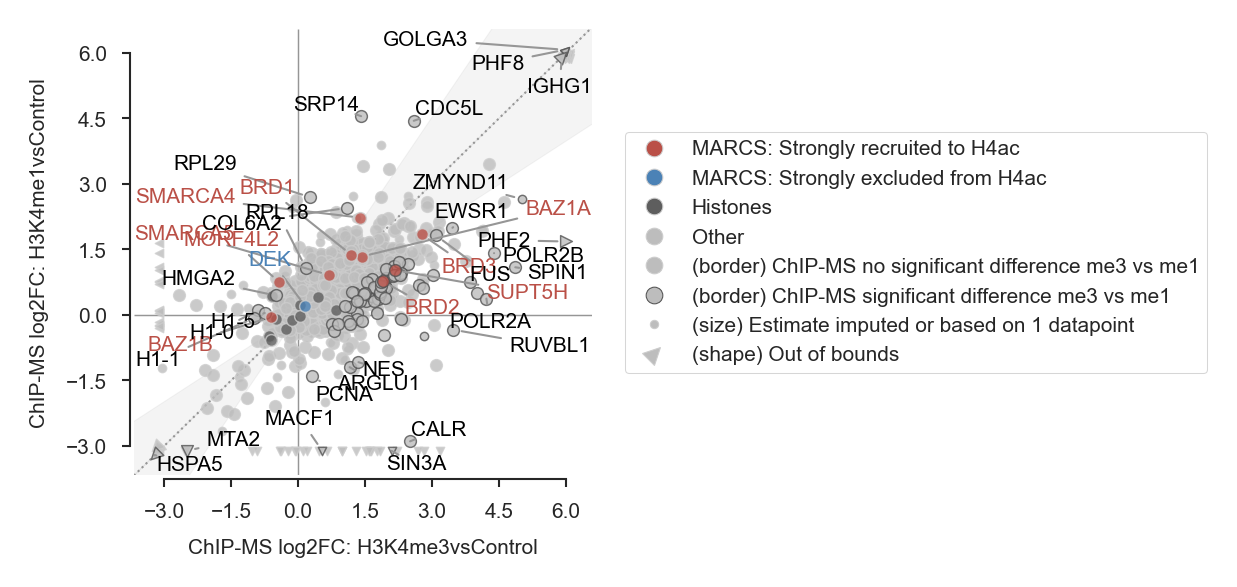

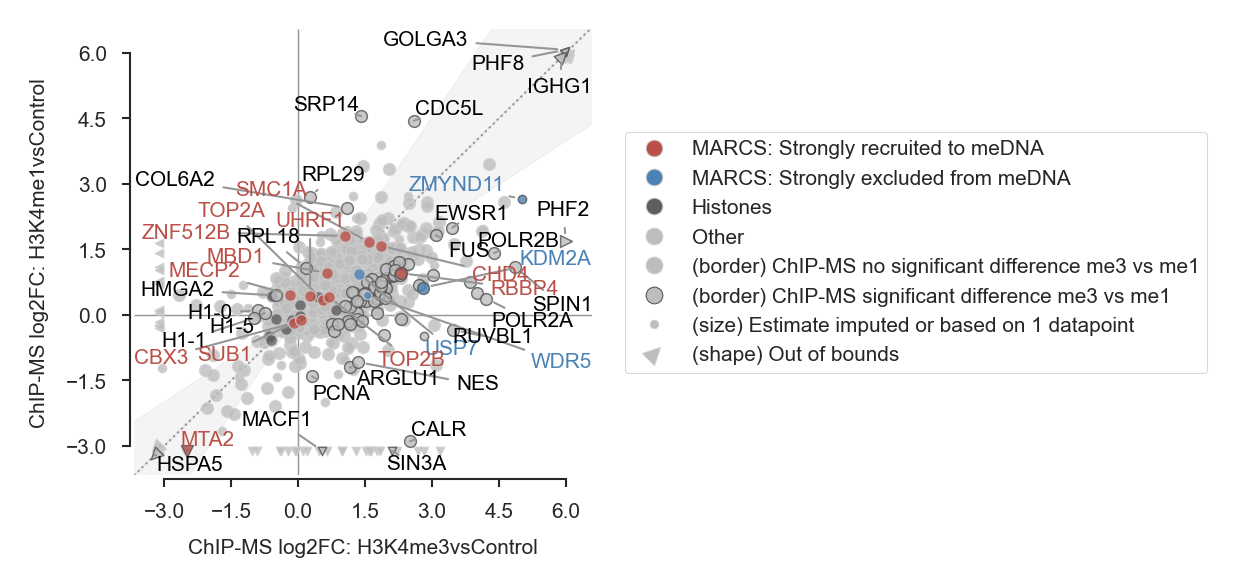

In [31]:
from sklearn.ensemble import IsolationForest
from matplotlib.markers import MarkerStyle
from numpy.random import RandomState
from matplotlib.lines import Line2D
from adjustText import adjust_text

#  --------- CONFIGS --------------

data_limits =  {
    'x': [-3, 6],
    'y': [-3, 6]
}

x_ticks = y_ticks = [-3, -1.5, 0, 1.5, 3, 4.5, 6]

approx_number_of_labels = 20

# random jitter width, in terms of fraction of data limits, 
# the jitter is used only for diagonal boundary items so they don't overlap so much
# all other out-of-bounds plots will be placed a jitter_max_offset away from the boundary
jitter_amplitude = 0.025 
jitter_max_offset_x = (data_limits['x'][1] - data_limits['x'][0])*jitter_amplitude/2
jitter_max_offset_y = (data_limits['y'][1] - data_limits['y'][0])*jitter_amplitude/2

effective_data_limits = {
    'x': (data_limits['x'][0] - jitter_max_offset_x, data_limits['x'][1] + jitter_max_offset_x),
    'y': (data_limits['y'][0] - jitter_max_offset_y, data_limits['y'][1] + jitter_max_offset_y),
}

_features = results_mwu.groupby('marcs_feature')['p-val'].apply(lambda x: (~x.isnull()).any())
_features = _features[_features].index

# -- helpers

def rotate_by_angle(point, theta):
    # https://scipython.com/book/chapter-6-numpy/examples/creating-a-rotation-matrix-in-numpy/
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    
    rotp = R.dot(point)
    return rotp


for marcs_feature_of_interest in _features:


    # ------------------ DATA -------------------------------------

    # We will need the model's outputs, so collect them
    plot_df = {}

    axes = dict([
        ('x', 'H3K4me3vsControl'),
        ('y', 'H3K4me1vsControl'),
        ('z', 'H3K4me3vsH3K4me1')
    ])

    for prefix, col in axes.items():
        plot_df[f'{prefix}_value'] = data_model_outputs[col, 'logFC_imputed']
        plot_df[f'{prefix}_is_imputed'] =  data_model_outputs[col, 'logFC_is_imputed']
        plot_df[f'{prefix}_is_one_datapoint']= data_model_outputs[col, 'logFC_based_on_single_datapoint']
        plot_df[f'{prefix}_is_significant'] = data_model_outputs[col, 'significant']

        # Make a special column to mark infinities
        plot_df[f'{prefix}_is_infinite'] = (~data_model_outputs[col, 'logFC_imputed'].isnull()) & (~data_model_outputs[col, 'logFC_imputed'].apply(np.isfinite))

    # Additionally, we would need to know which proteins were used in normalisation:
    plot_df['used_for_normalisation'] = data_model_outputs['comment', 'comment'].fillna('').str.contains('Used for normalisation')

    # As well as the classifications by the chosen MARCS feature
    plot_df['marcs_feature_classification'] = data_marcs_features['significant_category_strong', marcs_feature_of_interest]

    # Finally, we would need to know which points are "out of bounds" of the limits (i.e. are infinite)
    for prefix in ['x', 'y']:
        plot_df[f'{prefix}_is_in_bounds'] = plot_df[f'{prefix}_value'].between(*effective_data_limits[prefix])

    # Combine this into one dataframe
    plot_df = pd.DataFrame(plot_df)

    # We can drop proteins without x/y/z values as we either won't be able to plot anything for them anyway
    # Or they don't matter (if z value is missing)
    plot_df = plot_df.dropna(subset=['x_value', 'y_value', 'z_value'])

    # Add some summary columns:
    plot_df['any_one_datapoint'] = plot_df[['x_is_one_datapoint', 'y_is_one_datapoint', 'z_is_one_datapoint']].fillna(False).any(axis=1)
    plot_df['any_imputed'] = plot_df[['x_is_imputed', 'y_is_imputed', 'z_is_imputed']].fillna(False).any(axis=1)
    plot_df['any_infinite'] = plot_df[['x_is_infinite', 'y_is_infinite', 'z_is_infinite']].fillna(False).any(axis=1)
    plot_df['any_oob'] = ~(plot_df[['x_is_in_bounds', 'y_is_in_bounds']].fillna(True).all(axis=1))

    # Finally, we need to identify outlier proteins that we should label, within the significant proteins in bounds
    _df_if = plot_df[plot_df['x_is_in_bounds'] & plot_df['y_is_in_bounds'] & plot_df['z_is_significant']]

    _if = IsolationForest(
        random_state=42, 
        contamination=np.clip(approx_number_of_labels/len(_df_if), 1e-5, 0.5)
    )
    _outliers = _if.fit_predict(_df_if[['x_value', 'y_value']])
    _outliers = pd.Series((_outliers == -1), index=_df_if.index, name='is_outlier')        
    plot_df = plot_df.join(_outliers)

    # And proteins to label, which should be:
    # - outlier proteins,
    plot_df['to_label'] = plot_df['is_outlier'].fillna(False) 
    # # Proteins used for normalisation
    # commented out because their labels take a lot of space but add little information
    # plot_df['to_label'] |= plot_df['used_for_normalisation'] 
    # - Proteins highlighted by MARCS feature
    plot_df['to_label'] |= plot_df['marcs_feature_classification'].isin(['Strongly recruited', 'Strongly excluded'])
    # -  Proteins with significant changes and oob enrihcments
    plot_df['to_label'] |= plot_df['z_is_significant'] & plot_df['any_oob']

    # ---- Now figure out the aesthetics to use for each of the proteins-------

    # -- Colour and textcolour

    # Default to Background colour
    plot_df['colour'] = PALETTE['Background']
    plot_df['textcolour'] = PALETTE_TEXT['Background']
    # Mark normalisation proteins using controls colour
    plot_df.loc[plot_df['used_for_normalisation'], 'colour'] = PALETTE['Controls']
    plot_df.loc[plot_df['used_for_normalisation'], 'textcolour'] = PALETTE_TEXT['Controls']
    # Mark MARCS feature proteins using their colours
    plot_df.loc[plot_df['marcs_feature_classification'] == 'Strongly recruited', 'colour'] = PALETTE['Strongly recruited']
    plot_df.loc[plot_df['marcs_feature_classification'] == 'Strongly excluded', 'colour'] = PALETTE['Strongly excluded']
    plot_df.loc[plot_df['marcs_feature_classification'] == 'Strongly recruited', 'textcolour'] = PALETTE_TEXT['Strongly recruited']
    plot_df.loc[plot_df['marcs_feature_classification'] == 'Strongly excluded', 'textcolour'] = PALETTE_TEXT['Strongly excluded']


    # -- Z order is similar to colour

    # Background is 0
    plot_df['z_order'] = 1

    # Significant things and controls are 2
    plot_df.loc[plot_df['used_for_normalisation'], 'z_order'] = 2
    plot_df.loc[plot_df['z_is_significant'], 'z_order'] = 2

    # MARCS features are 3
    plot_df.loc[
        plot_df['marcs_feature_classification'].isin(['Strongly recruited', 'Strongly excluded']),
        'z_order'
    ] = 3


    # And everything we want to annotate gets +1
    plot_df.loc[plot_df['to_label'], 'z_order'] += 1

    # -- Alpha:

    plot_df['alpha'] = ALPHA

    #  -- Edgecolour and thickness:

    # Default to background, and EDGEWIDTH
    plot_df['edgecolour'] = PALETTE_EDGES['background']
    plot_df['linewidth'] = EDGEWIDTH

    # For significant proteins in z direction add a darker border
    plot_df.loc[plot_df['z_is_significant'].fillna(False), 'edgecolour'] = PALETTE_EDGES['highlight']

    # -- Markersize: 

    # default to large
    plot_df['markersize'] = MARKERSIZES['large']

    # For imputed entries, or entries based on a single datapoint make it smaller
    plot_df.loc[
        plot_df['any_one_datapoint'], 
        'markersize'
    ] = MARKERSIZES['small']

    plot_df.loc[
        plot_df['any_imputed'], 
        'markersize'
    ] = MARKERSIZES['small']

    # -- The marker

    SPECIAL_MARKERS = {
    }

    SPECIAL_MARKERS['diag-down-left'] = MarkerStyle(marker='<')
    SPECIAL_MARKERS['diag-down-left']._transform = SPECIAL_MARKERS['diag-down-left'].get_transform().rotate_deg(45)

    SPECIAL_MARKERS['diag-up-right'] = MarkerStyle(marker='^')
    SPECIAL_MARKERS['diag-up-right']._transform = SPECIAL_MARKERS['diag-up-right'].get_transform().rotate_deg(-45)

    SPECIAL_MARKERS['diag-down-right'] = MarkerStyle(marker='>')
    SPECIAL_MARKERS['diag-down-right']._transform = SPECIAL_MARKERS['diag-down-right'].get_transform().rotate_deg(-45)

    SPECIAL_MARKERS['diag-up-left'] = MarkerStyle(marker='<')
    SPECIAL_MARKERS['diag-up-left']._transform = SPECIAL_MARKERS['diag-up-left'].get_transform().rotate_deg(-45)

    def figure_out_marker(row):

        _in_bounds = row[['x_is_in_bounds', 'y_is_in_bounds']].astype(bool)
        if _in_bounds.all():
            # If everything is in bounds, return 'o'
            return 'o'
        elif (~_in_bounds).all():
            # If nothing is in bounds
            # Let's figure out the direction
            if (row['x_value'] < data_limits['x'][0]) & (row['y_value'] < data_limits['y'][0]):
                # Lower left
                return 'diag-down-left'
            elif (row['x_value'] < data_limits['x'][0]) & (row['y_value'] > data_limits['y'][1]):
                # Upper left
                return 'diag-up-left'
            elif (row['x_value'] > data_limits['x'][1]) & (row['y_value'] < data_limits['y'][0]):
                # Lower right
                return 'diag-down-right'
            elif (row['x_value'] > data_limits['x'][1]) & (row['y_value'] > data_limits['y'][1]):
                # Upper right
                return 'diag-up-right'
            else:
                raise Exception("this case should never be reached")
        elif ~_in_bounds['x_is_in_bounds']:
            # If only x is out of bounds, then depending on the coordinate
            # return either < or >
            if row['x_value'] < data_limits['x'][0]:
                return '<'
            else:
                return '>'
        elif ~_in_bounds['y_is_in_bounds']:
            # If only y is out of bounds, then depending on the coordinate
            # return either v or ^
            if row['y_value'] < data_limits['y'][0]:
                return 'v'
            else:
                return '^'
        else:
            raise Exception("This condition should not happen")

    plot_df['marker'] = plot_df.apply(figure_out_marker, axis=1)


    # -- Rasterization
    # Rasterize everything background and with standard marker
    plot_df['rasterized'] = (plot_df['colour'] == PALETTE['Background']) & (plot_df['marker'] == 'o')

    # --- Coordinates 

    # Just clip the x values by the data limits, markers will highlight the in/out of axes points
    plot_df['x_coord'] = plot_df['x_value'].clip(effective_data_limits['x'][0], data_limits['x'][1])
    plot_df['y_coord'] = plot_df['y_value'].clip(effective_data_limits['y'][0], data_limits['y'][1])

    # Add some jitter to the coordinates that are equal to maximum data limits
    _at_limits = ~(plot_df[['x_is_in_bounds', 'y_is_in_bounds']].astype(bool).any(axis=1))

    random = RandomState(45)

    plot_df.loc[_at_limits, 'x_coord'] += random.uniform(-jitter_max_offset_x, jitter_max_offset_x, size=_at_limits.sum())
    plot_df.loc[_at_limits, 'y_coord'] += random.uniform(-jitter_max_offset_y, jitter_max_offset_y, size=_at_limits.sum())


    # --------- LEGEND ---------------------------


    legend = [
        Line2D([0], [0], 
               marker='o', color='none', label=f'MARCS: Strongly recruited to {marcs_feature_of_interest}', 
               markerfacecolor=PALETTE['Strongly recruited'], markersize=MARKERSIZES['large'],
               markeredgecolor=PALETTE_EDGES['background']),
        Line2D([0], [0], 
               marker='o', color='none', label=f'MARCS: Strongly excluded from {marcs_feature_of_interest}', 
               markerfacecolor=PALETTE['Strongly excluded'], markersize=MARKERSIZES['large'],
               markeredgecolor=PALETTE_EDGES['background']),
        Line2D([0], [0], 
               marker='o', color='none', label=f'Histones',
               markerfacecolor=PALETTE['Controls'], markersize=MARKERSIZES['large'],
               markeredgecolor=PALETTE_EDGES['background']),
        Line2D([0], [0], 
               marker='o', color='none', label='Other', 
               markerfacecolor=PALETTE['Background'], markersize=MARKERSIZES['large'],
               markeredgecolor=PALETTE_EDGES['background']),

        Line2D([0], [0], 
               marker='o', color='none', label='(border) ChIP-MS no significant difference me3 vs me1', 
               markerfacecolor=PALETTE['Background'], markersize=MARKERSIZES['large'],
               markeredgecolor=PALETTE_EDGES['background']),

        Line2D([0], [0], 
               marker='o', color='none', label='(border) ChIP-MS significant difference me3 vs me1', 
               markerfacecolor=PALETTE['Background'], markersize=MARKERSIZES['large'],
               markeredgecolor=PALETTE_EDGES['highlight']),

        Line2D([0], [0], 
               marker='o', color='none', label='(size) Estimate imputed or based on 1 datapoint', 
               markerfacecolor=PALETTE['Background'], markersize=MARKERSIZES['small'],
               markeredgecolor=PALETTE_EDGES['background']),
        Line2D([0], [0], 
               marker=SPECIAL_MARKERS['diag-up-right'], color='none', label='(shape) Out of bounds', 
               markerfacecolor=PALETTE['Background'], markersize=MARKERSIZES['large'],
               markeredgecolor=PALETTE_EDGES['background']),
    ]

    # -------- TExt for caption -----------

    out_of_bounds_text = []
    for ix, row in plot_df.loc[~plot_df[['x_is_in_bounds', 'y_is_in_bounds']].astype(bool).all(axis=1)].sort_index().iterrows():
        out_of_bounds_text.append('{}: (x={:.2f}, y={:.2f}, z={:.2f}{})'.format(ix, row['x_value'], row['y_value'], row['z_value'], '*' if row['z_is_significant'] else ''))

    out_of_bounds_text = '- ' + ('\n- '.join(out_of_bounds_text))

    # ---------- PLOTS ----------------




    fig = plt.figure(figsize=(10*FIVE_MM_IN_INCH, 10*FIVE_MM_IN_INCH))
    ax = plt.gca()

    ax.axhline(0, linestyle='-', color=AXIS_LINECOLOR, linewidth=EDGEWIDTH, zorder=0)
    ax.axvline(0, linestyle='-', color=AXIS_LINECOLOR, linewidth=EDGEWIDTH, zorder=0)

    texts = []

    for aesthetics, rows in plot_df.groupby([
        'to_label', 'colour', 'textcolour', 'z_order', 'alpha', 'edgecolour', 'linewidth', 'markersize', 'marker', 'rasterized'
    ]):
        to_label, colour, textcolour, z_order, alpha, edgecolour, linewidth, markersize, marker, rasterized = aesthetics

        if marker in SPECIAL_MARKERS:
            marker = SPECIAL_MARKERS[marker]

        ax.scatter(
            x=rows['x_coord'], y=rows['y_coord'], 
            color=colour, zorder=z_order, 
            alpha=alpha, edgecolor=edgecolour, 
            linewidth=linewidth,
            s=markersize,
            marker=marker,
            rasterized=rasterized,
        )

        if to_label:
            for ix, row in rows.iterrows():
                texts.append(ax.text(row['x_coord'], row['y_coord'], ix, color=textcolour, zorder=plot_df['z_order'].max()))

    adjust_text(
        texts, 
        plot_df['x_coord'].values, plot_df['y_coord'].values, 
        ax=ax,
        force_points=(0.5, 0.5), 
        force_text=(0.25, 0.25),
        arrowprops=dict(arrowstyle='-', color=AXIS_LINECOLOR, linewidth=0.5)
    )
    ax.grid(False)

    _xlim = ax.get_xlim()
    _ylim = ax.get_ylim()

    _min = np.min([_xlim, _ylim])
    _max = np.max([_xlim, _ylim])

    ax.plot([_min, _max], [_min, _max], linestyle=':', linewidth=0.5, zorder=0, color=AXIS_LINECOLOR)
    ## Shading around diagonal  (positive/negative)
    angle_offset = 0.2 # Same as in other figures in main text
    # Diagonal shading
    absmax = np.max(np.abs([_xlim, _ylim]))
    line_drawing_limit = absmax * 2
    vector = np.asarray([1,1]) * line_drawing_limit
    shading_dict = dict(color='#969696', alpha=.1, zorder=0)

    for sign_symmetry in [-1.0, 1.0]:
        for sign_angle in [-1.0, 1.0]:
            rotated_vector = rotate_by_angle(sign_symmetry * vector, sign_symmetry * sign_angle * angle_offset)  

            ax.fill_between(
                [0, rotated_vector[0]],
                [0, rotated_vector[0]],
                [0, rotated_vector[1]],
                **shading_dict,
            )

    ax.set_xlim(_xlim)
    ax.set_ylim(_ylim)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)

    ax.set_xlabel('ChIP-MS log2FC: {}'.format(axes['x']))
    ax.set_ylabel('ChIP-MS log2FC: {}'.format(axes['y']))

    ax.legend(handles=legend, loc='center left', bbox_to_anchor=(1.05, 0.5), markerscale=0.5)

    sns.despine(ax=ax, offset=1, trim=True)

    _fname = OUTPUT_DIRECTORY / f'05-scatterplot-marcs-{marcs_feature_of_interest}-vs-chip-ms.pdf'
    _caption = f"""

Scaterplots of all proteins with ChIP-MS model outputs.
On the X axis, the imputed estimate of H3K4me3vsControl log2 fold change is plotted.
On the Y axis, the imputed estimate of H3K4me1vsControl log2 fold change is plotted.

Each marker corresponds to a protein in ChIP-MS data, for which we have such estimates.

The darker border around certain markers indicates that the H3K4me3vsH3K4me1 difference is statistically significant.
Smaller markers indicate that one of the three estimates (me1/3 vs Control, or me3 vs me1) was imputed or is based on a single datapoint. 

Histone proteins are highlighted in dark grey.
And the proteins strongly recruited to MARCS feature {marcs_feature_of_interest} are highlighted in red.
Proteins strongly excluded from MARCS feature {marcs_feature_of_interest} are highlighted in blue.

The labels are placed on out-of-bounds proteins that are significantly different me3 vs me1, 
on proteins in MARCS feature categories, and on a small selection of other significantly differential me3 vs me1 proteins.

Triangle markers indicate points that are out of the axis bounds. The axis bounds are set to: x={data_limits['x']}, y={data_limits['y']}), 
but implemented with some leeway as x={effective_data_limits['x']}, y={effective_data_limits['y']}. This
was done so points that fall on a boundary (e.g. x = 3.01) do not appear out of bounds (as that would be misleading).

Note that the markers at the corners of the plot (diagonal triangles) have been plotted with some random noise added so they do not overlap on a single point.
This random noise should not be interpreted in any way.

The out-of-bounds cases frequently happen when the effect estimates are infinite. A list of out of bounds proteins is printed below.
x,y axes correspond to plot axes, z axis corresponds to the difference between me3 and me1. A star next to the z estimate indicates statistical significance.

{out_of_bounds_text}

    """
    plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
    with open(str(_fname) + '.caption.md', 'w') as f:
        f.write(_caption)
        print(_caption)

    plot_df.to_csv(str(_fname) + '.plot_data.csv')